# The problem Statement

**Problem:** predict next year’s sales for each store, accounting for seasonality, holidays, promotions, and other external factors, to enable effective marketing planning and resource allocation

**Task:** develop a forecasting model to accurately predict daily sales for each store using historical data, incorporating variables such as promotions, holidays, school closures, and customer patterns

**Data Source:** https://www.kaggle.com/c/rossmann-store-sales/data

**Data fields**
Most of the fields are self-explanatory. The following are descriptions for those that aren't.

- Id - an Id that represents a (Store, Date) duple within the test set
- Store - a unique Id for each store
- Sales - the turnover for any given day (our target)
- Customers - the number of customers on a given day
- Open - an indicator for whether the store was open: 0 = closed, 1 = open
- StateHoliday - indicates a state holiday. Normally all stores, with few exceptions, are closed on state holidays. Note that all schools are closed on public holidays and weekends. a = public holiday, b = Easter holiday, c = Christmas, 0 = None
- SchoolHoliday - indicates if the (Store, Date) was affected by the closure of public schools
- StoreType - differentiates between 4 different store models: a, b, c, d
- Assortment - describes an assortment level: a = basic, b = extra, c = extended
- CompetitionDistance - distance in meters to the nearest competitor store
- CompetitionOpenSince[Month/Year] - gives the approximate year and month of the time the nearest competitor was opened
- Promo - indicates whether a store is running a promo on that day
- Promo2 - Promo2 is a continuing and consecutive promotion for some stores: 0 = store is not participating, 1 = store is participating
- Promo2Since[Year/Week] - describes the year and calendar week when the store started participating in Promo2
- PromoInterval - describes the consecutive intervals Promo2 is started, naming the months the promotion is started anew. E.g. "Feb,May,Aug,Nov" means each round starts in February, May, August, November of any given year for that store

# Import Libriries and Datasets

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import datetime
import scipy.stats as stats
import pingouin as pg
# from scipy.stats import levene
sns.set()

In [4]:
store_data_original = pd.read_csv('datasets/store.csv')
sales_data_original = pd.read_csv('datasets/train.csv', dtype={7: 'object'})

In [5]:
store_info_data = store_data_original.copy()
sales_data = sales_data_original.copy()

In [6]:
# set mdates for future visualisation
years = mdates.YearLocator()
months = mdates.MonthLocator()
years_fmt = mdates.DateFormatter('%Y')

# Preliminary Data Exploration and Preprocessing

##  SALES DATA

In [7]:
sales_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1017209 entries, 0 to 1017208
Data columns (total 9 columns):
 #   Column         Non-Null Count    Dtype 
---  ------         --------------    ----- 
 0   Store          1017209 non-null  int64 
 1   DayOfWeek      1017209 non-null  int64 
 2   Date           1017209 non-null  object
 3   Sales          1017209 non-null  int64 
 4   Customers      1017209 non-null  int64 
 5   Open           1017209 non-null  int64 
 6   Promo          1017209 non-null  int64 
 7   StateHoliday   1017209 non-null  object
 8   SchoolHoliday  1017209 non-null  int64 
dtypes: int64(7), object(2)
memory usage: 69.8+ MB


In [8]:
sales_data.isnull().sum()

Store            0
DayOfWeek        0
Date             0
Sales            0
Customers        0
Open             0
Promo            0
StateHoliday     0
SchoolHoliday    0
dtype: int64

In [9]:
sales_data.duplicated().sum()

0

**The sales_data dataset does not have any missing or duplicated values.**

In [10]:
sales_data.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1


In [11]:
# let's check values in DayOfWeek,	Open,	Promo,	StateHoliday,	SchoolHoliday columns
for col in ['DayOfWeek', 'Open', 'Promo', 'StateHoliday', 'SchoolHoliday']:
    print(f'{col}: {sales_data[col].unique()}')

DayOfWeek: [5 4 3 2 1 7 6]
Open: [1 0]
Promo: [1 0]
StateHoliday: ['0' 'a' 'b' 'c']
SchoolHoliday: [1 0]


**We need to update the data in the StateHoliday column based on the list above, where a = public holiday, b = Easter holiday, c = Christmas, and 0 = regular day, ensuring no data type conflicts or misleading results. Additionally, we should convert both the StateHoliday and DayOfWeek columns to the category data type.**

In [12]:
# Update the data in the StateHoliday column
sales_data['StateHoliday'] = sales_data['StateHoliday'].map({'a': 'Public_holiday',
                                                             'b': 'Easter_holiday',
                                                             'c': 'Christmas',
                                                             '0': 'regular_day',}).astype('category')

In [13]:
# Convert the 'StateHoliday' column into dummy/one-hot encoded variables
dummies = pd.get_dummies(sales_data['StateHoliday']).astype(int)
dummies = dummies.drop('regular_day', axis=1)
sales_data = pd.concat([sales_data, dummies], axis=1).drop('StateHoliday', axis=1)
sales_data.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,SchoolHoliday,Christmas,Easter_holiday,Public_holiday
0,1,5,2015-07-31,5263,555,1,1,1,0,0,0
1,2,5,2015-07-31,6064,625,1,1,1,0,0,0
2,3,5,2015-07-31,8314,821,1,1,1,0,0,0
3,4,5,2015-07-31,13995,1498,1,1,1,0,0,0
4,5,5,2015-07-31,4822,559,1,1,1,0,0,0


In [14]:
# Let's check Christmas date
sales_data[sales_data.Christmas == 1]["Date"].value_counts()

Date
2013-12-26    1115
2013-12-25    1115
2014-12-26     935
2014-12-25     935
Name: count, dtype: int64

In [15]:
# Remove 26 Dec from Christmas scope
sales_data.loc[sales_data['Date'].isin(["2013-12-26", "2014-12-26"]), 'Christmas'] = 0

In [16]:
# Check Christmas again
sales_data[sales_data.Christmas == 1]["Date"].value_counts()

Date
2013-12-25    1115
2014-12-25     935
Name: count, dtype: int64

In [17]:
# Let's check Easter date
sales_data[sales_data.Easter_holiday == 1]["Date"].value_counts()

Date
2015-04-06    1115
2015-04-03    1115
2014-04-21    1115
2014-04-18    1115
2013-04-01    1115
2013-03-29    1115
Name: count, dtype: int64

The correct Easter dates are as follows: 2015 - April 5, 2014 - April 20, and 2013 - March 31. To maintain data consistency for future modeling, let's retain the closest variants for the given dates.

In [18]:
sales_data.loc[sales_data['Date'].isin(["2015-04-03", "2014-04-18", "2013-03-29" ]), 'Easter_holiday'] = 0

In [19]:
# Check Easter dates again
sales_data[sales_data.Easter_holiday == 1]["Date"].value_counts()

Date
2015-04-06    1115
2014-04-21    1115
2013-04-01    1115
Name: count, dtype: int64

In [20]:
# Check the data type of the 'Date' column
sales_data['Date'].dtype

dtype('O')

**The Date column is currently of type Object, so it needs to be converted to datetime. This will allow us to extract the day, month, year, and day of the week for further analysis.**

In [21]:
# Convert the 'Date' column to datetime object
sales_data['Date'] = pd.to_datetime(sales_data['Date'])

# Extract numerical features from the 'Date' column
sales_data['Year'] = sales_data['Date'].dt.year
sales_data['Month'] = sales_data['Date'].dt.month
sales_data['Day'] = sales_data['Date'].dt.day
sales_data['DayOfWeek'] = sales_data['Date'].dt.dayofweek  # Monday=0, Sunday=6
sales_data['Date'].dtype

dtype('<M8[ns]')

In [22]:
sales_data = sales_data[['Store',  'Sales', 'Customers', 'Open', 'Promo',
                      'Date', 'Year', 'Month', 'Day', 'DayOfWeek',
                      'SchoolHoliday', 'Christmas', 'Easter_holiday', 'Public_holiday']]

In [23]:
sales_data.sample(5)

,Store,Sales,Customers,Open,Promo,Date,Year,Month,Day,DayOfWeek,SchoolHoliday,Christmas,Easter_holiday,Public_holiday
240640,622,3548,354,1,0,2014-12-27,2014,12,27,5,0,0,0,0
660892,483,1560,233,1,0,2013-11-16,2013,11,16,5,0,0,0,0
1012817,68,5645,1023,1,0,2013-01-04,2013,1,4,4,1,0,0,0
620184,1030,9267,791,1,0,2013-12-23,2013,12,23,0,1,0,0,0
542850,631,0,0,0,0,2014-03-02,2014,3,2,6,0,0,0,0


**Now, let’s examine the "Open" column. How many stores were closed and why?**

In [24]:
sales_data['Open'].value_counts()

Open
1    844392
0    172817
Name: count, dtype: int64

In [25]:
s = sales_data['Sales'] == 0
print(s.value_counts())

Sales
False    844338
True     172871
Name: count, dtype: int64


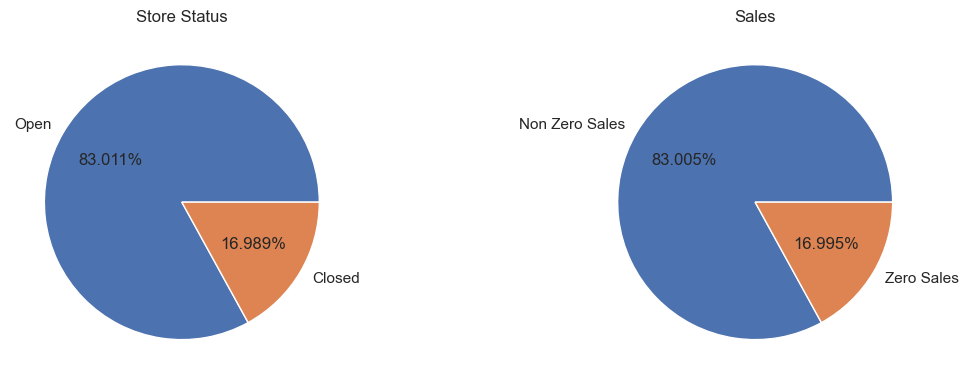

In [26]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))

# First pie chart for Store Status
sales_data['Open'].value_counts().plot(
    kind='pie',
    labels=['Open', 'Closed'],
    autopct='%1.3f%%',
    title='Store Status',
    ylabel='',
    ax=ax[0]  
)

# Second pie chart for Sales Status
(sales_data['Sales'] == 0).value_counts().plot(
    kind='pie',
    labels=['Non Zero Sales', 'Zero Sales'],
    autopct='%1.3f%%',
    title='Sales',
    ylabel='',
    ax=ax[1]  
)

plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()

**`17% of the entries correspond to stores that were closed on specific dates, and it appears that zero sales are primarily associated with the closed status of these stores. However, the correlation is not exact, as we observe a slight difference: 16.989% of stores were closed, while 16.995% reflect zero sales, indicating that some zero sales are not related to store closures.**

In [27]:
# Let's also check if there are any open stores with sales equal to zero
open_zero_sales = sales_data[(sales_data['Open'] == 1) & (sales_data['Sales'] == 0)]
open_zero_sales.head()

,Store,Sales,Customers,Open,Promo,Date,Year,Month,Day,DayOfWeek,SchoolHoliday,Christmas,Easter_holiday,Public_holiday
86825,971,0,0,1,0,2015-05-15,2015,5,15,4,1,0,0,0
142278,674,0,0,1,0,2015-03-26,2015,3,26,3,0,0,0,0
196938,699,0,0,1,1,2015-02-05,2015,2,5,3,0,0,0,0
322053,708,0,0,1,1,2014-10-01,2014,10,1,2,0,0,0,0
330176,357,0,0,1,0,2014-09-22,2014,9,22,0,0,0,0,0


**There are 54 entries with zero sales despite the store not being marked as closed. This may indicate a potential issue or error in the data.**

**Let's also identify the specific dates on which the stores were closed.**

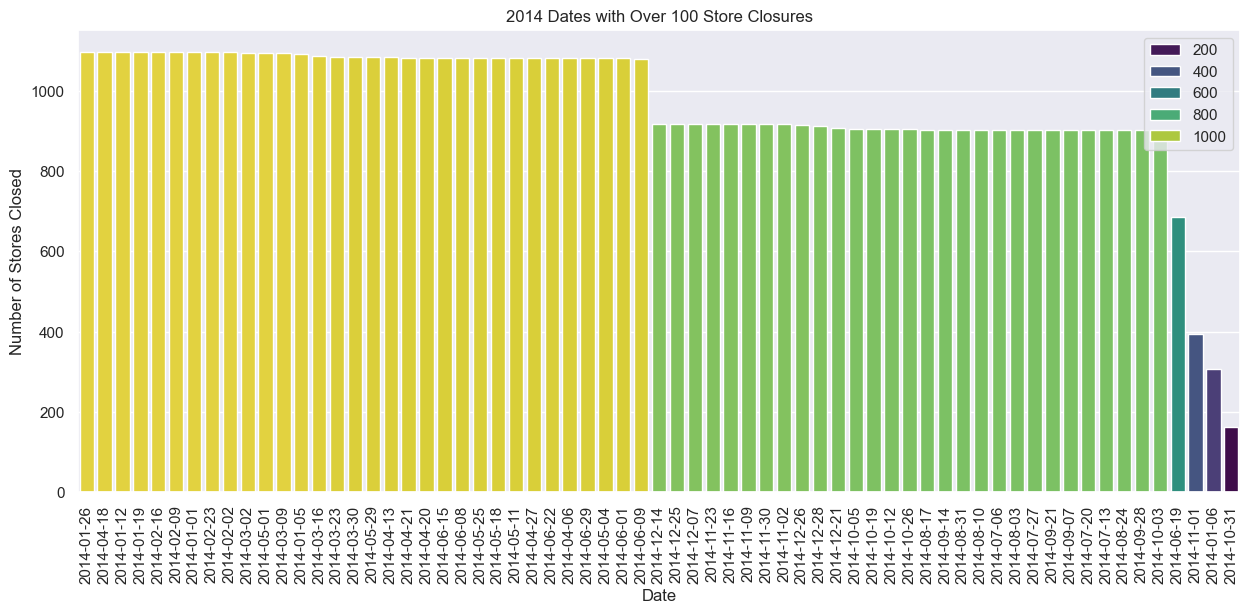

In [28]:
plt.figure(figsize=(15, 6))
closed_stores = sales_data[(sales_data['Open'] == 0) & (sales_data['Year'] == 2014)]['Date'].value_counts()
filtered_counts = closed_stores[closed_stores > 100]

sns.barplot(x=filtered_counts.index, y=filtered_counts.values, palette="viridis", hue=filtered_counts.values)
plt.title("2014 Dates with Over 100 Store Closures")
plt.xlabel("Date")
plt.ylabel("Number of Stores Closed")
plt.xticks(rotation=90) 
plt.show()

**Many bars reach a height of 1000 closures, indicating that on certain dates(Christmas, Easter..), nearly all stores were closed. These are likely to be public holidays or other events affecting store operations universally.**

**Approximately 17% of the time, the stores in the dataset are closed for various reasons, primarily due to holiday closures. On these days, sales equal 0, making the data irrelevant for sales forecasting. Therefore, we will remove these entries from the dataset for future analysis.**

In [29]:
# Let's save the dates of all public holidays in a separate dataset (to retain that information for forecasting)
# and exclude data with 0 sales for the upcoming EDA.

holidays = sales_data[['Date', 'Easter_holiday', 'Christmas', 'Public_holiday', 'SchoolHoliday']]
holidays_melted = holidays.melt(id_vars='Date', 
                                var_name='Holiday_Type', 
                                value_name='Is_Holiday')

holidays_filtered = holidays_melted[holidays_melted['Is_Holiday'] == 1].copy()

holiday_label_map = {
    'Easter_holiday': 'Easter',
    'Christmas': 'Christmas',
    'Public_holiday': 'Public Holiday',
    'SchoolHoliday': 'School Holiday'
}
holidays_filtered['Holiday_Label'] = holidays_filtered['Holiday_Type'].map(holiday_label_map)
public_holidays_df = holidays_filtered[['Date', 'Holiday_Label']].drop_duplicates()
public_holidays_df.to_csv('datasets/public_holidays.csv', index=False)

In [30]:
#  exclude data with 0 sales for the upcoming EDA and remove Open col from the dataset
sales_data = sales_data[sales_data['Sales'] != 0]
sales_data = sales_data.drop('Open', axis=1)

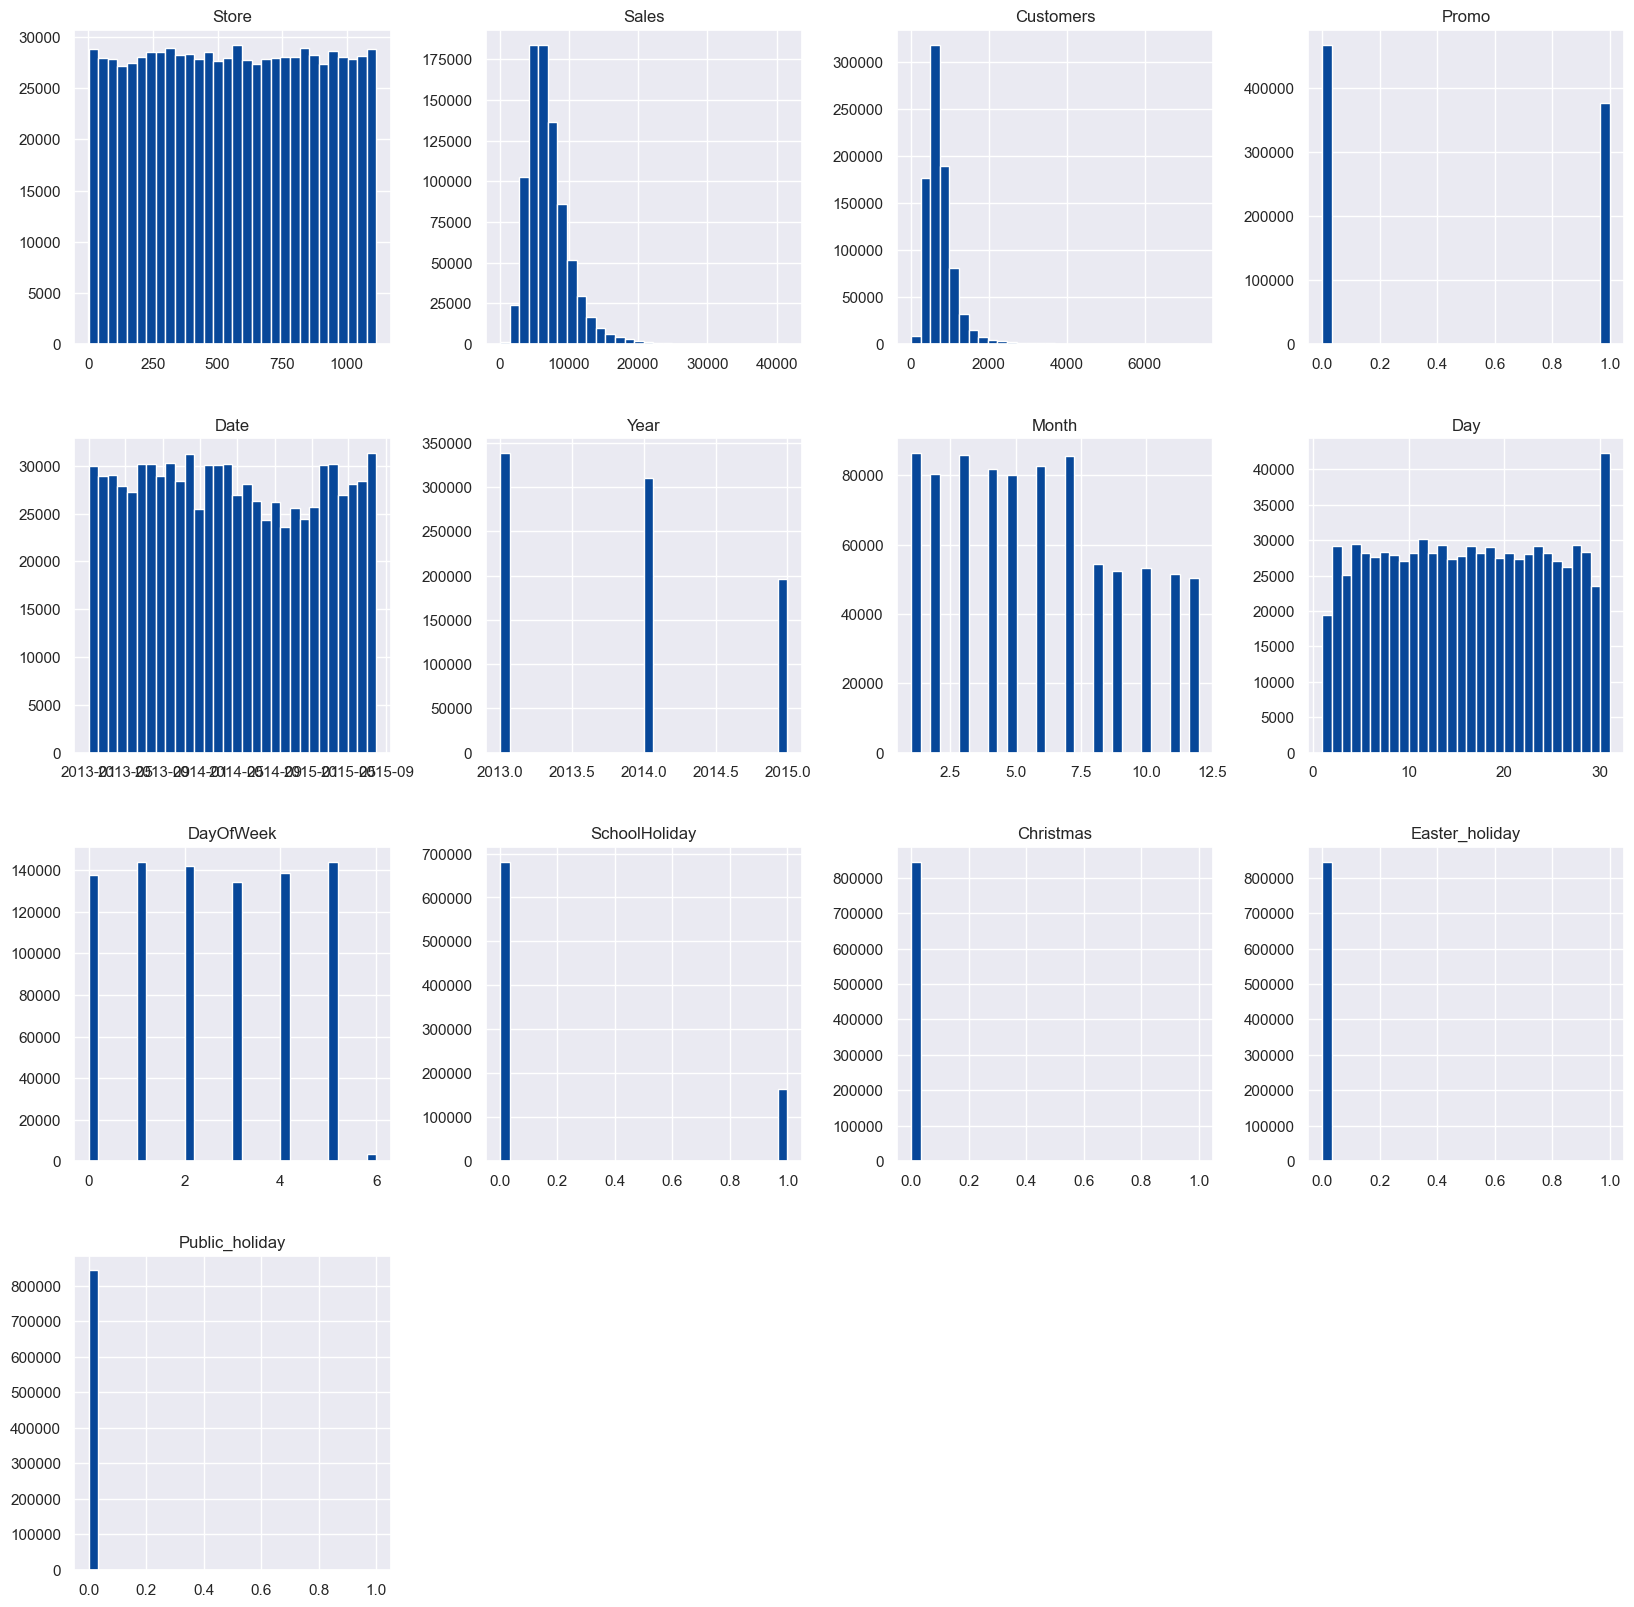

In [31]:
sales_data.hist(bins=30, figsize=(20, 20), color='#074799')
plt.show()

In [32]:
sales_data.describe()

,Store,Sales,Customers,Promo,Date,Year,Month,Day,DayOfWeek,SchoolHoliday,Christmas,Easter_holiday,Public_holiday
count,844338.000000,844338.000000,844338.000000,844338.000000,844338,844338.000000,844338.000000,844338.000000,844338.000000,844338.000000,844338.000000,844338.000000,844338.000000
mean,558.421374,6955.959134,762.777166,0.446356,2014-04-11 01:08:38.729702912,2013.831945,5.845774,15.835706,2.520350,0.193578,0.000039,0.000113,0.000822
min,1.000000,46.000000,8.000000,0.000000,2013-01-01 00:00:00,2013.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,280.000000,4859.000000,519.000000,0.000000,2013-08-16 00:00:00,2013.000000,3.000000,8.000000,1.000000,0.000000,0.000000,0.000000,0.000000
50%,558.000000,6369.000000,676.000000,0.000000,2014-03-31 00:00:00,2014.000000,6.000000,16.000000,2.000000,0.000000,0.000000,0.000000,0.000000
75%,837.000000,8360.000000,893.000000,1.000000,2014-12-11 00:00:00,2014.000000,8.000000,23.000000,4.000000,0.000000,0.000000,0.000000,0.000000
max,1115.000000,41551.000000,7388.000000,1.000000,2015-07-31 00:00:00,2015.000000,12.000000,31.000000,6.000000,1.000000,1.000000,1.000000,1.000000
std,321.730861,3103.815515,401.194153,0.497114,NaN,0.777271,3.323959,8.683392,1.723712,0.395102,0.006252,0.010607,0.028658


The resulting dataset contains 844,338 observations across various columns, including store identifiers, day of the week, sales, customer counts, promotional activity, holiday flags, and time-related features (year, month, day, and day of the week)

**Store Identification (Store)**

- Count: 844338 records for 1115 unique stores.
- The store IDs range from 1 to 1115, providing a balanced distribution across stores.

**Time Representation**

-  The dates span from 2013-01-01 to 2015-07-31, with observations taken over nearly 3 years.
-  DayOfWeek_num ranges from 0 (Sunday) to 6 (Saturday), with mean = 2.52, slightly favoring weekdays over weekends.
-  Month ranges from 1 (January) to 12 (December), with May (mean = 5.85) being the most common month, indicating possible seasonality in sales.
-  Day ranges from 1 to 31, with mean = 15.83, suggesting data is fairly evenly distributed across days within months.

**Sales and Customer Metrics**

**Sales (Sales):**
- The average daily sales amount to €6,955, with a substantial range from €0 to €41,551.
- High variability is evident, as the standard deviation of €3,104 reflects large fluctuations in daily sales. The median is €6,369, with 25% of the data below €4,859 and 25% above €8,360.
- This variation may be driven by promotional events, seasonality, or special holidays.
  
 **Customers (Customers):**
- The mean customer count is 762, with a standard deviation of 401, ranging from 0 to 7,388.
- The dataset contains a wide variation in customer numbers, with a significant number of entries showing low to no customers, possibly due to shop closures or data anomalies.

**Promotional Activity (Promo)**

- On average, 44.6% of observations involve a promotion, highlighting its significance in store operations.
- Promotional campaigns likely drive variability in sales and customer numbers.

**Holiday Indicators**

- **School Holidays (SchoolHoliday):**
Represent 19.4% of the timeframe, indicating their potential influence on sales patterns.
- **Special Holiday Flags (Christmas, Easter_holiday, Public_holiday):**
These events are infrequent, with respective averages of 0.000039%	0.000113% and 0.000822%. This is likely due to the exclusion of data with 0 sales (closed stores).

**Distribution Insights**
- Sales and Customers: Both metrics exhibit skewness, with extreme maximum values (e.g., sales of €41,551 and 7,388 customers) likely tied to promotions or holiday peaks.
- Promo Effect: The binary nature of Promo makes it a key variable to assess its impact on sales and customer behavior.
- Holiday Influence: Sparse yet critical holiday flags can be leveraged to analyze their specific contribution to performance metrics.

## STORES INFORMATION DATA

In [33]:
store_info_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1115 entries, 0 to 1114
Data columns (total 10 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Store                      1115 non-null   int64  
 1   StoreType                  1115 non-null   object 
 2   Assortment                 1115 non-null   object 
 3   CompetitionDistance        1112 non-null   float64
 4   CompetitionOpenSinceMonth  761 non-null    float64
 5   CompetitionOpenSinceYear   761 non-null    float64
 6   Promo2                     1115 non-null   int64  
 7   Promo2SinceWeek            571 non-null    float64
 8   Promo2SinceYear            571 non-null    float64
 9   PromoInterval              571 non-null    object 
dtypes: float64(5), int64(2), object(3)
memory usage: 87.2+ KB


In [34]:
store_info_data.isnull().sum()

Store                          0
StoreType                      0
Assortment                     0
CompetitionDistance            3
CompetitionOpenSinceMonth    354
CompetitionOpenSinceYear     354
Promo2                         0
Promo2SinceWeek              544
Promo2SinceYear              544
PromoInterval                544
dtype: int64

In [35]:
store_info_data.duplicated().sum()

0

**Half of the columns in the store data contain null values. Let's fix it**

In [36]:
store_info_data[store_info_data['CompetitionDistance'].isnull()]

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
290,291,d,a,NaN,NaN,NaN,0,NaN,NaN,NaN
621,622,a,c,NaN,NaN,NaN,0,NaN,NaN,NaN
878,879,d,a,NaN,NaN,NaN,1,5.0,2013.0,"Feb,May,Aug,Nov"


In [37]:
# Let's replace the NaN values in the CompetitionDistance column with the mean for that category

store_info_data['CompetitionDistance'] = store_info_data['CompetitionDistance'].fillna(store_info_data['CompetitionDistance'].mean())

In [38]:
store_info_data[store_info_data['CompetitionOpenSinceMonth'].isnull()].head()

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
11,12,a,c,1070.0,NaN,NaN,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
12,13,d,a,310.0,NaN,NaN,1,45.0,2009.0,"Feb,May,Aug,Nov"
15,16,a,c,3270.0,NaN,NaN,0,NaN,NaN,NaN
18,19,a,c,3240.0,NaN,NaN,1,22.0,2011.0,"Mar,Jun,Sept,Dec"
21,22,a,a,1040.0,NaN,NaN,1,22.0,2012.0,"Jan,Apr,Jul,Oct"


**Let's replace the NaN values in'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 'Promo2SinceWeek', 'Promo2SinceYear' with 0**


In [39]:
cols_for_null = ['CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 'Promo2SinceWeek', 'Promo2SinceYear']

In [40]:
for col in cols_for_null:
    store_info_data[col] = store_info_data[col].fillna(0)

**Next, let's change the data type of the StoreType and Assortment columns to category, and convert the CompetitionOpenSinceMonth, CompetitionOpenSinceYear, Promo2SinceWeek, and Promo2SinceYear columns to int32 type.**

In [41]:
# First, let's inspect the values in those columns.
cols = ['StoreType', 'Assortment', 'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 'Promo2SinceWeek', 'Promo2SinceYear']
for col in cols:
    print(store_info_data[col].unique())

['c' 'a' 'd' 'b']
['a' 'c' 'b']
[ 9. 11. 12.  4. 10.  8.  0.  3.  6.  5.  1.  2.  7.]
[2008. 2007. 2006. 2009. 2015. 2013. 2014. 2000. 2011.    0. 2010. 2005.
 1999. 2003. 2012. 2004. 2002. 1961. 1995. 2001. 1990. 1994. 1900. 1998.]
[ 0. 13. 14.  1. 45. 40. 26. 22.  5.  6. 10. 31. 37.  9. 39. 27. 18. 35.
 23. 48. 36. 50. 44. 49. 28.]
[   0. 2010. 2011. 2012. 2009. 2014. 2015. 2013.]


In [42]:
# change the data type
store_info_data[['StoreType', 'Assortment']] = store_info_data[['StoreType', 'Assortment']].astype('category')
store_info_data[['CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 'Promo2SinceWeek', 'Promo2SinceYear']] = store_info_data[['CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 'Promo2SinceWeek', 'Promo2SinceYear']].astype('int32')

In [43]:
store_info_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1115 entries, 0 to 1114
Data columns (total 10 columns):
 #   Column                     Non-Null Count  Dtype   
---  ------                     --------------  -----   
 0   Store                      1115 non-null   int64   
 1   StoreType                  1115 non-null   category
 2   Assortment                 1115 non-null   category
 3   CompetitionDistance        1115 non-null   float64 
 4   CompetitionOpenSinceMonth  1115 non-null   int32   
 5   CompetitionOpenSinceYear   1115 non-null   int32   
 6   Promo2                     1115 non-null   int64   
 7   Promo2SinceWeek            1115 non-null   int32   
 8   Promo2SinceYear            1115 non-null   int32   
 9   PromoInterval              571 non-null    object  
dtypes: category(2), float64(1), int32(4), int64(2), object(1)
memory usage: 54.9+ KB


**let's handle the PromoInterval values by splitting them and converting them into corresponding month numbers.**

In [44]:
# split values
separated_PromoInterval  = store_info_data.PromoInterval.str.split(',', expand=True).rename(columns={0: 'PromoStartMonth1', 
                                                                                                     1: 'PromoStartMonth2', 
                                                                                                     2: 'PromoStartMonth3', 
                                                                                                     3: 'PromoStartMonth4'})
separated_PromoInterval.head()

,PromoStartMonth1,PromoStartMonth2,PromoStartMonth3,PromoStartMonth4
0,NaN,NaN,NaN,NaN
1,Jan,Apr,Jul,Oct
2,Jan,Apr,Jul,Oct
3,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN


In [45]:
# find unique values in each col
for col in separated_PromoInterval.columns:
    print(separated_PromoInterval[col].unique())

[nan 'Jan' 'Feb' 'Mar']
[nan 'Apr' 'May' 'Jun']
[nan 'Jul' 'Aug' 'Sept']
[nan 'Oct' 'Nov' 'Dec']


In [46]:
# transform month names into numbers
separated_PromoInterval = separated_PromoInterval.map(lambda x: 'Sep' if x == 'Sept' else x)
separated_PromoInterval  = separated_PromoInterval.map(lambda x: pd.to_datetime(x, format='%b').month if pd.notna(x) else 0)

In [47]:
for col in separated_PromoInterval.columns:
    print(separated_PromoInterval[col].unique())

[0 1 2 3]
[0 4 5 6]
[0 7 8 9]
[ 0 10 11 12]


In [48]:
# concatenate data to store_info_data
store_info_data = pd.concat([store_info_data, separated_PromoInterval], axis=1).drop('PromoInterval', axis=1)
store_info_data.head()

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoStartMonth1,PromoStartMonth2,PromoStartMonth3,PromoStartMonth4
0,1,c,a,1270.0,9,2008,0,0,0,0,0,0,0
1,2,a,a,570.0,11,2007,1,13,2010,1,4,7,10
2,3,a,a,14130.0,12,2006,1,14,2011,1,4,7,10
3,4,c,c,620.0,9,2009,0,0,0,0,0,0,0
4,5,a,a,29910.0,4,2015,0,0,0,0,0,0,0


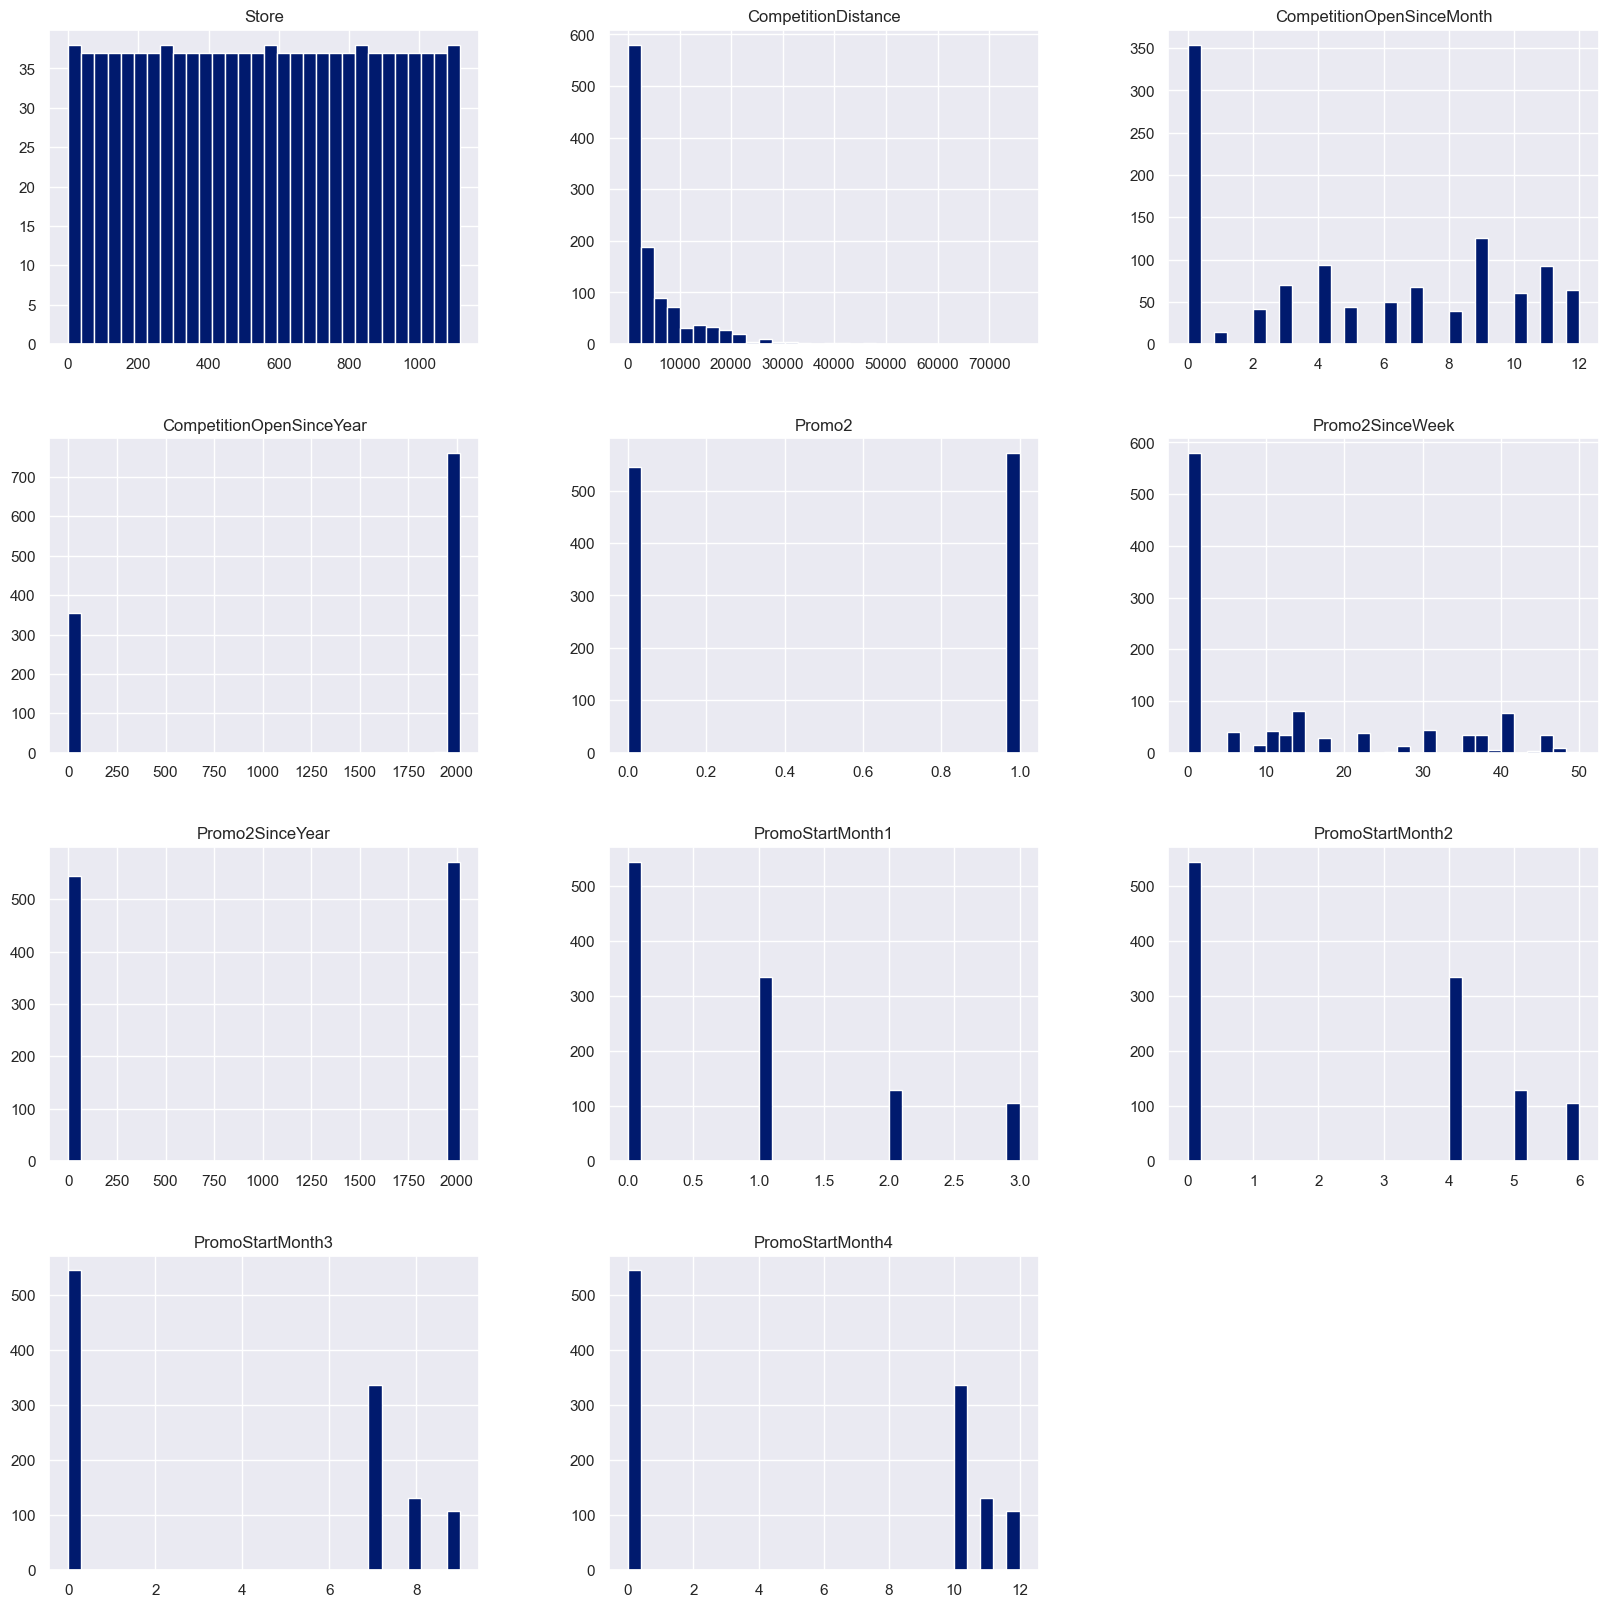

In [49]:

store_info_data.hist(bins=30, figsize=(20, 20), color='#001A6E')
plt.show()

In [50]:
store_info_data.describe()

,Store,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoStartMonth1,PromoStartMonth2,PromoStartMonth3,PromoStartMonth4
count,1115.00000,1115.000000,1115.000000,1115.000000,1115.000000,1115.000000,1115.000000,1115.000000,1115.000000,1115.000000,1115.000000
mean,558.00000,5404.901079,4.930942,1370.939013,0.512108,12.083408,1030.239462,0.818834,2.355157,3.891480,5.427803
std,322.01708,7652.849306,4.284924,935.467654,0.500078,15.542241,1006.038782,0.976108,2.366993,3.841083,5.329783
min,1.00000,20.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,279.50000,720.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,558.00000,2330.000000,4.000000,2006.000000,1.000000,1.000000,2009.000000,1.000000,4.000000,7.000000,10.000000
75%,836.50000,6875.000000,9.000000,2011.000000,1.000000,22.000000,2012.000000,1.000000,4.000000,7.000000,10.000000
max,1115.00000,75860.000000,12.000000,2015.000000,1.000000,50.000000,2015.000000,3.000000,6.000000,9.000000,12.000000


In [51]:
store_info_data.Promo2SinceYear.unique()

array([   0, 2010, 2011, 2012, 2009, 2014, 2015, 2013])

**Store:**
 - There are 1,115 stores in the dataset, with store IDs ranging from 1 to 1,115.

**CompetitionDistance:**

- The average distance to the nearest competitor is around 5,405 meters, with a standard deviation of approximately 7,653 meters.
- The minimum distance is 20 meters, and the maximum distance is 75,860 meters, indicating some stores may have very distant competitors.

**CompetitionOpenSinceMonth:**

- The distribution shows a majority of stores report competition opening during later months of the year.

**CompetitionOpenSinceYear:**

- The average year for the competition opening is around 2010, with values ranging from 1900 to 2015.

**Promo2:**

- Around 51% of the stores are involved in a promotional campaign (Promo2), with the rest not participating. 

**Promo2SinceWeek:**

- The average week for Promo2 activity to start is week 12, with values spanning from week 0 (missing) to week 50. This suggests most promotions started within the first half of the year.

**Promo2SinceYear:**

- The promotional activity associated with Promo2 typically started in 2009, with values ranging from 2009 to 2015.

**PromoMonth1 to PromoMonth4:**

- These columns represent the months in which the store runs promotions. The month columns are coded numerically (e.g., 1 for January, 4 for April, etc.), and there is a clear pattern showing that promotions tend to be distributed throughout the year, with a higher concentration of stores running promotions in January, April, July, and October.
- The standard deviation for each of these columns suggests that not all stores use the same promotional calendar, with the frequency of months appearing more or less consistent across the dataset.

In [52]:
# merge all info in 1 df
full_sales_info_df = pd.merge(sales_data, store_info_data, on='Store', how='inner')

In [53]:
full_sales_info_df.to_csv('datasets/preprocessed_full_sales_data.csv')

# Features analysis and visualisation

## Correlation analysis

In [54]:
datetime_format = "%Y-%m-%d" 
df = pd.read_csv(
    'datasets/preprocessed_full_sales_data.csv',
    index_col=0,
    parse_dates=['Date'], 
    date_format=datetime_format  
)

In [55]:
sales_corr = df.select_dtypes(include=np.number).corr()['Sales'].sort_values()
sales_corr

DayOfWeek                   -0.178753
PromoStartMonth2            -0.134979
PromoStartMonth3            -0.132985
PromoStartMonth4            -0.131742
PromoStartMonth1            -0.131638
Promo2SinceYear             -0.127581
Promo2                      -0.127556
Promo2SinceWeek             -0.058493
Day                         -0.051865
CompetitionDistance         -0.036401
CompetitionOpenSinceMonth   -0.018369
Easter_holiday               0.003388
Christmas                    0.004176
CompetitionOpenSinceYear     0.005257
Store                        0.007723
Public_holiday               0.014152
Year                         0.036151
SchoolHoliday                0.038635
Month                        0.073589
Promo                        0.368199
Customers                    0.823552
Sales                        1.000000
Name: Sales, dtype: float64

**Our target variable (Sales) shows a strong correlation with Customers (0.89) and a moderate correlation with Promo (0.37).**




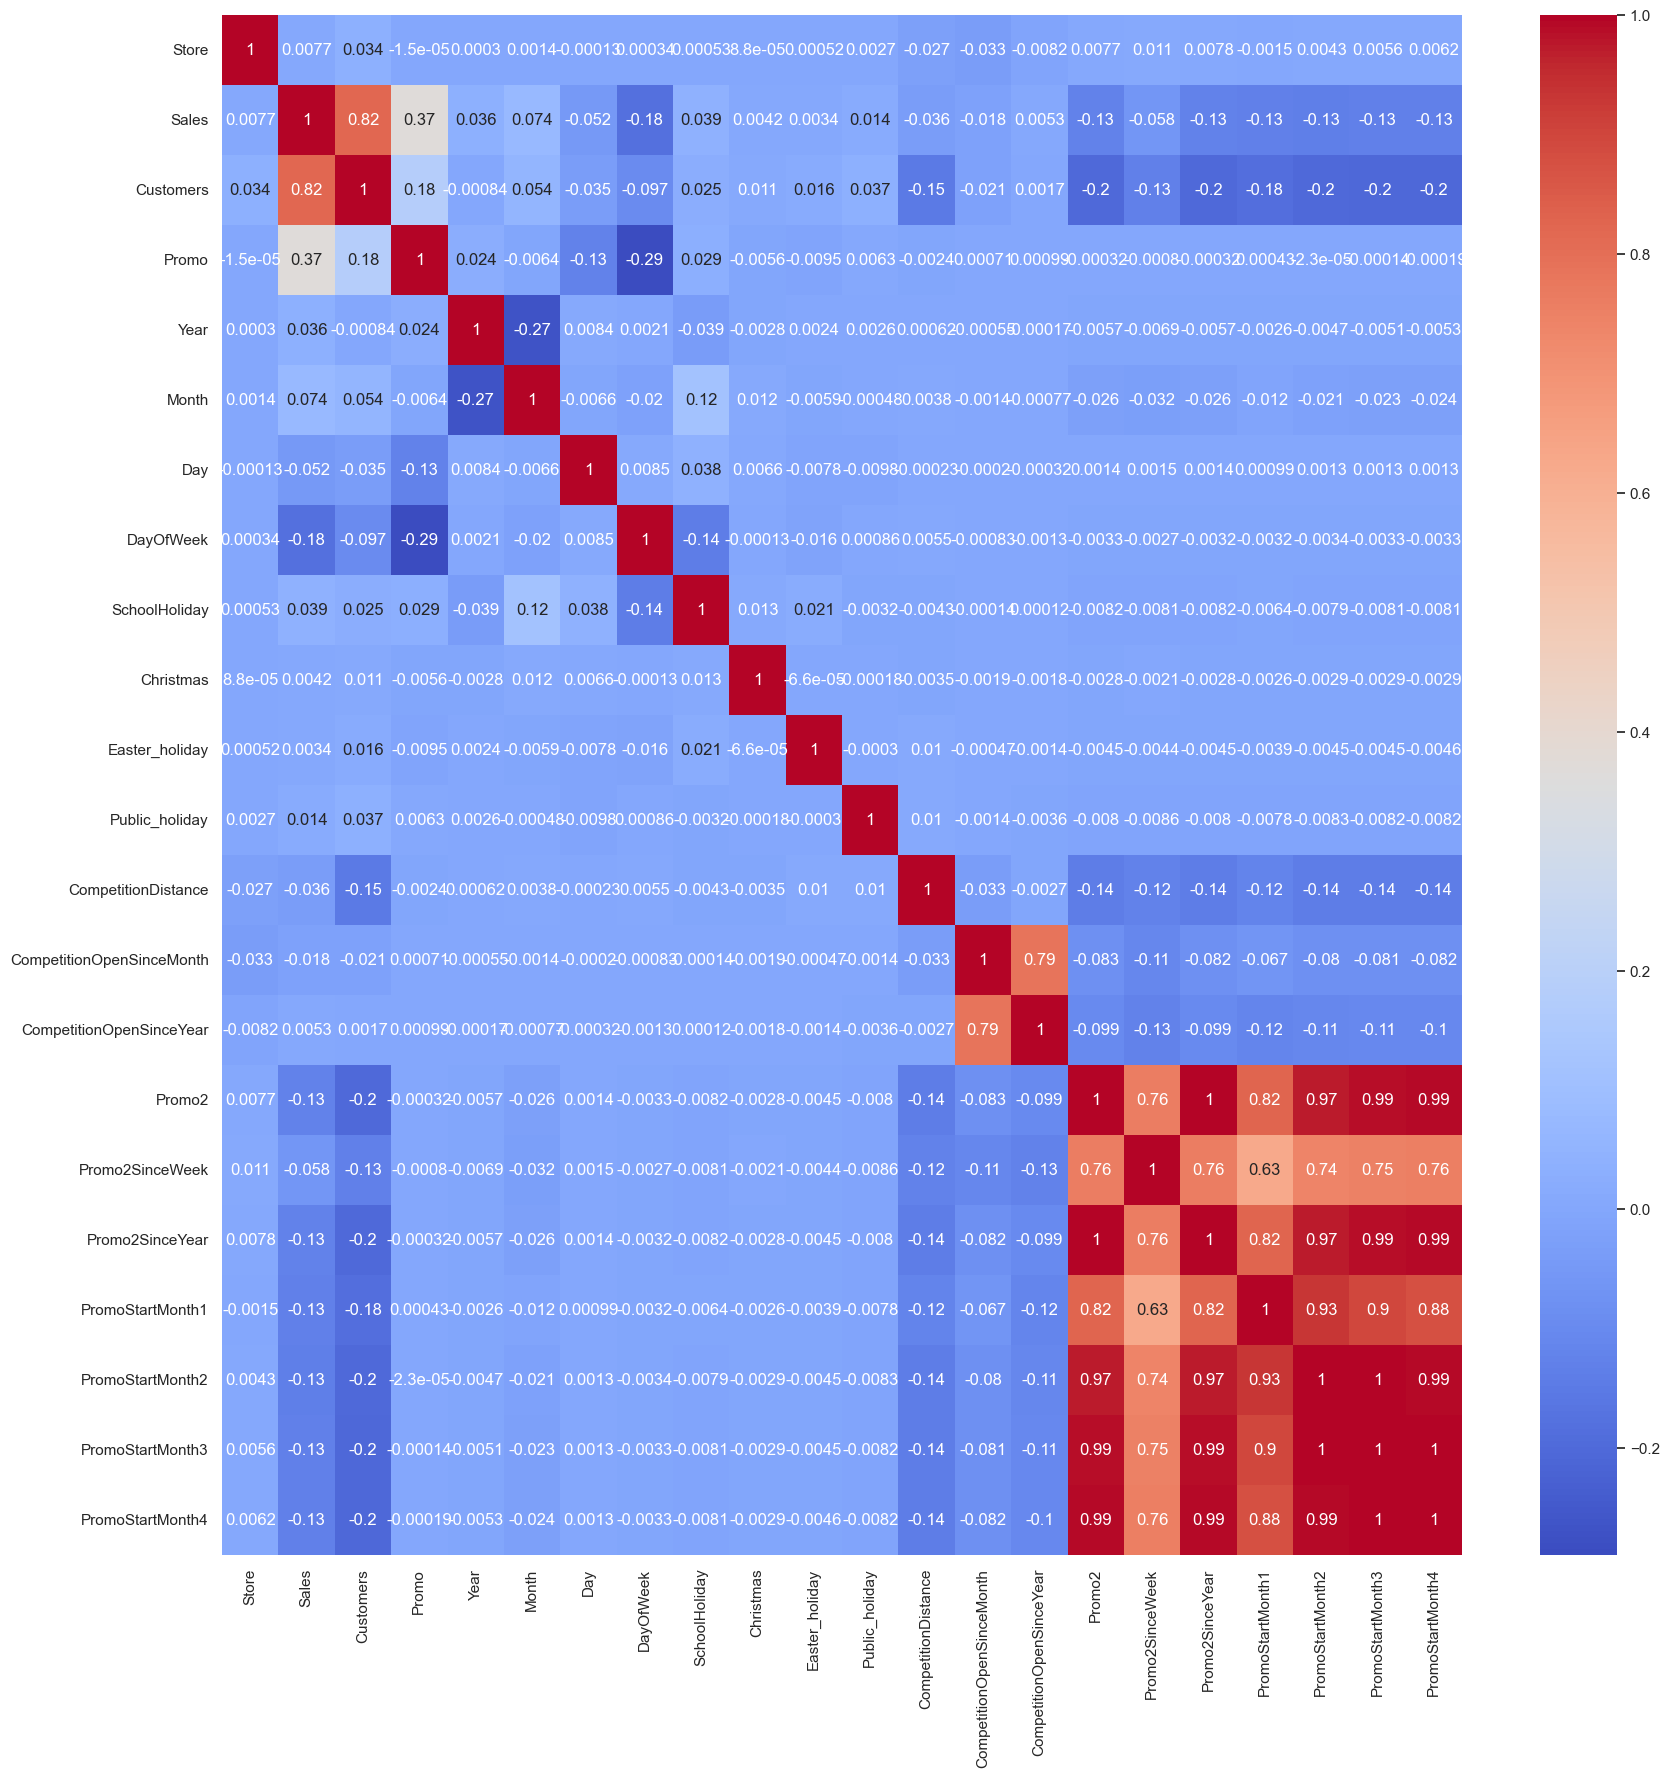

In [56]:
corr_all = df.select_dtypes(include=np.number).corr()
f, ax = plt.subplots(figsize=(20, 20))
sns.heatmap(corr_all, annot=True, cmap='coolwarm')
plt.show()

**Strong Correlations:**

- Sales has a very strong positive correlation with Customers (0.82), indicating that higher customer counts are strongly associated with increased sales.
- Promo moderately correlates with Sales (0.37), suggesting that promotional activities positively impact sales, though not as significantly as customer count.

**Promo and Related Variables:**

- Promo2 is highly correlated with Promo2SinceYear and Promo2SinceWeek (~0.76), which is expected as these variables are closely related.

**Competition Variables:**

- CompetitionOpenSinceMonth and CompetitionOpenSinceYear show a strong correlation (~0.79), reflecting the time-based relationship between these fields.
- CompetitionDistance has weak correlations with other variables, indicating limited direct influence on key metrics like sales or promotions.

**Time-Based Features:**

- Month, Day, and Year generally show weak correlations with other variables, implying they might not significantly affect sales directly in this dataset.

## Trends in Sales and Customers: Daily, Weekly, and Monthly

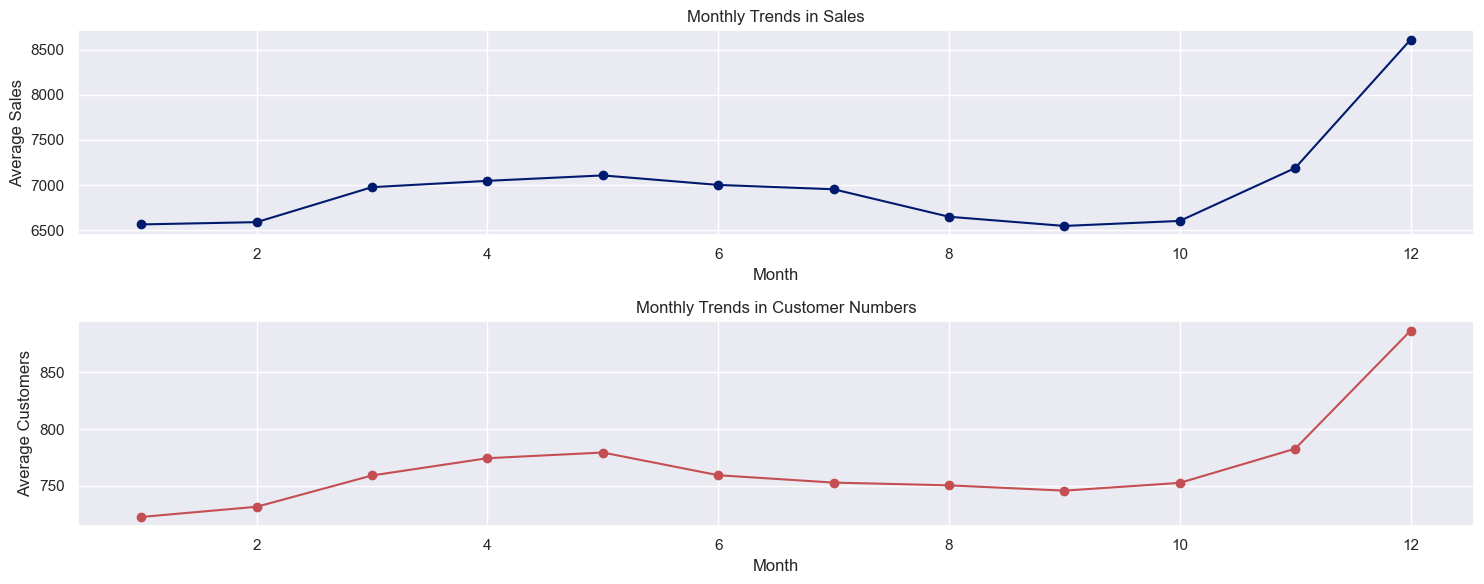

In [57]:
# Let's check monthly trends in sales and customers
monthly_data = df.groupby("Month")[['Sales', 'Customers']].mean()

fig, ax = plt.subplots(2, 1, figsize=(15, 6))


monthly_data['Sales'].plot(ax=ax[0], marker='o',  color='#001A6E',  title="Monthly Trends in Sales")
ax[0].set_ylabel("Average Sales")
ax[0].set_xlabel("Month")

monthly_data['Customers'].plot(ax=ax[1],  marker='o',   color='r',  title="Monthly Trends in Customer Numbers")
ax[1].set_ylabel("Average Customers")
ax[1].set_xlabel("Month")


plt.tight_layout()
plt.show()

**We observe a slight increase in customer activity and sales during the spring months, with a significant rise in December, likely due to pre-Christmas activity.**

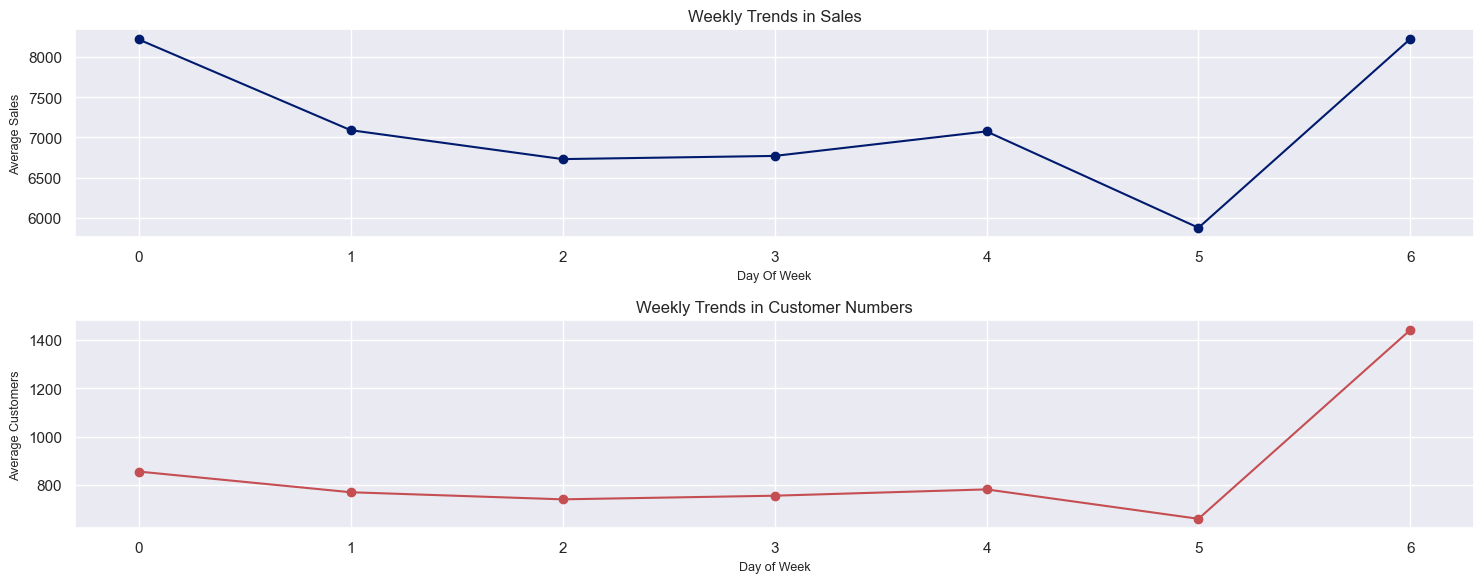

In [58]:
# Weekly data
weekly_data = df.groupby("DayOfWeek")[['Sales', 'Customers']].mean()

fig, ax = plt.subplots(2, 1, figsize=(15, 6))

weekly_data['Sales'].plot(ax=ax[0], marker='o', color='#001A6E',  title="Weekly Trends in Sales")
ax[0].set_ylabel("Average Sales", fontsize=9)
ax[0].set_xlabel("Day Of Week", fontsize=9)

weekly_data['Customers'].plot(ax=ax[1],  marker='o',  color='r',  title="Weekly Trends in Customer Numbers")
ax[1].set_ylabel("Average Customers", fontsize=9)
ax[1].set_xlabel("Day of Week", fontsize=9)

plt.tight_layout()
plt.show()

**Customer activity and sales are evenly distributed throughout the weekdays, with an upward trend on the weekends.**

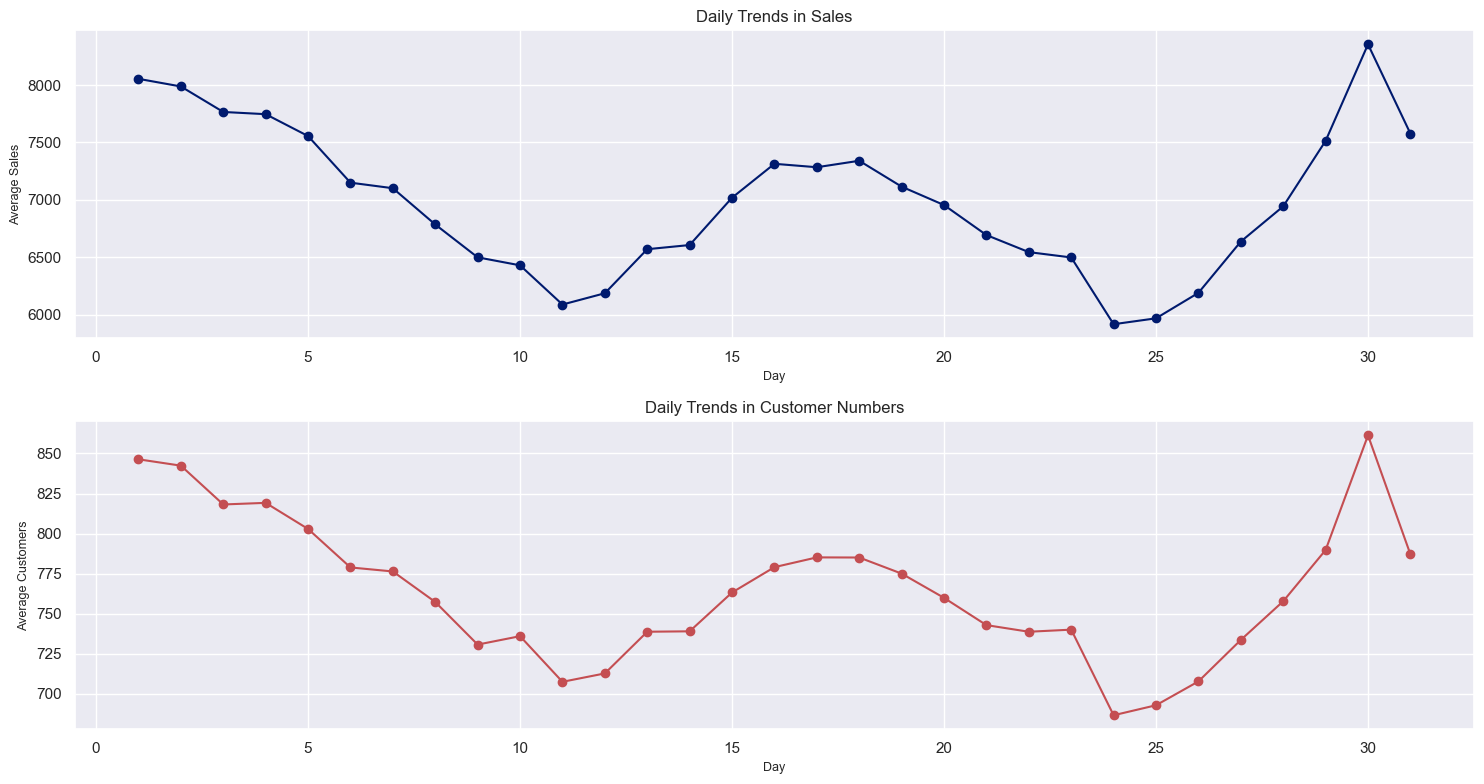

In [59]:
# Let's check daily trends in sales and customers
daily_data = df.groupby("Day")[['Sales', 'Customers']].mean()

fig, ax = plt.subplots(2, 1, figsize=(15, 8))


daily_data['Sales'].plot(ax=ax[0], marker='o',  color='#001A6E',  title="Daily Trends in Sales")
ax[0].set_ylabel("Average Sales", fontsize=9)
ax[0].set_xlabel("Day", fontsize=9)

daily_data['Customers'].plot(ax=ax[1],  marker='o',   color='r',  title="Daily Trends in Customer Numbers")
ax[1].set_ylabel("Average Customers", fontsize=9)
ax[1].set_xlabel("Day", fontsize=9)


plt.tight_layout()
plt.show()

**The daily trends show two peaks: one around the middle of the month (17-18) and another at the end (30-31), likely driven by salary payment cycles.**

## Analysis of Holiday Impact

**As we observed in our previous data analysis, many stores are closed on Christmas and other public holidays, leading to zero sales on those days, which we excluded from the dataset. To analyze sales during holidays more consistently, we will define a time window for each holiday.**

In [83]:
holidays = pd.read_csv('datasets/public_holidays.csv', parse_dates=['Date'])

In [94]:
holidays.Holiday_Label.value_counts()

Holiday_Label
School Holiday    478
Public Holiday     27
Easter              3
Christmas           2
Name: count, dtype: int64

In [97]:
# Filter public holidays
public_holidays = holidays[holidays['Holiday_Label'] != 'School Holiday']

In [96]:
# Function to compute date window
def compute_date_window(row, window_before, window_after):
    date = row['Date']
    # Generate a full range of dates for the window
    date_window = pd.date_range(
        start=date - pd.Timedelta(days=window_before),
        end=date + pd.Timedelta(days=window_after)
    )
    return date_window

expanded_rows = []

for _, row in public_holidays.iterrows():
    date_window = compute_date_window(row=row, window_before=window_before, window_after=window_after)
    for window_date in date_window:
        expanded_rows.append({'Date': window_date, 'Holiday_Label': row['Holiday_Label']})

expanded_public_holidays_df = pd.DataFrame(expanded_rows)
expanded_public_holidays_df = expanded_holidays_df.sort_values(by='Date').reset_index(drop=True)

In [99]:
# Lets concatenate our expanded Public holidays and School holidays
school_holidays = holidays[holidays['Holiday_Label'] == 'School Holiday']
result_holidays = pd.concat([expanded_public_holidays_df, school_holidays], axis=0, ignore_index=True)

In [110]:
# Merge result holidays with df
sales_customers_df = df[['Sales', 'Customers', 'Date']]
sales_in_holidays = pd.merge(result_holidays, sales_customers_df, how='inner', on='Date')

# Define working days
sales_in_working_days = sales_customers_df[~sales_customers_df['Date'].isin(result_holidays['Date'])]

In [111]:
# Let's briefly access mean Sales and Customers for holidays
sales_in_holidays.groupby('Holiday_Label')[['Sales', 'Customers']].mean()

,Sales,Customers
Holiday_Label,,
Christmas,9725.036134,993.769435
Easter,8932.363152,917.112832
Public Holiday,7094.370505,781.742935
School Holiday,6992.335766,767.334293


In [112]:
# Mean Sales and Customers for ordinary days
sales_in_working_days[['Sales', 'Customers']].mean()

Sales        6777.539664
Customers     750.812860
dtype: float64

In [113]:
sales_in_holidays

,Date,Holiday_Label,Sales,Customers
0,2013-01-01,School Holiday,4220,619
1,2013-01-01,School Holiday,6851,1444
2,2013-01-01,School Holiday,17267,2875
3,2013-01-01,School Holiday,3102,729
4,2013-01-01,School Holiday,2401,482
...,...,...,...,...
4539067,2013-01-01,School Holiday,3375,566
4539068,2013-01-01,School Holiday,10765,2377
4539069,2013-01-01,School Holiday,5035,1248
4539070,2013-01-01,School Holiday,4491,1039


In [114]:
# Make individual DataFrames for plotting
main_holidays = sales_in_holidays[sales_in_holidays['Holiday_Label'].isin(['Christmas', 'Easter', 'Public Holiday'])]
school_holidays = sales_in_holidays[sales_in_holidays['Holiday_Label'].isin(['School Holiday'])]
christmas = sales_in_holidays[sales_in_holidays['Holiday_Label'].isin(['Christmas'])]
easter = sales_in_holidays[sales_in_holidays['Holiday_Label'].isin(['Easter'])]
public = sales_in_holidays[sales_in_holidays['Holiday_Label'].isin(['Public Holiday'])]
working_days = sales_in_working_days

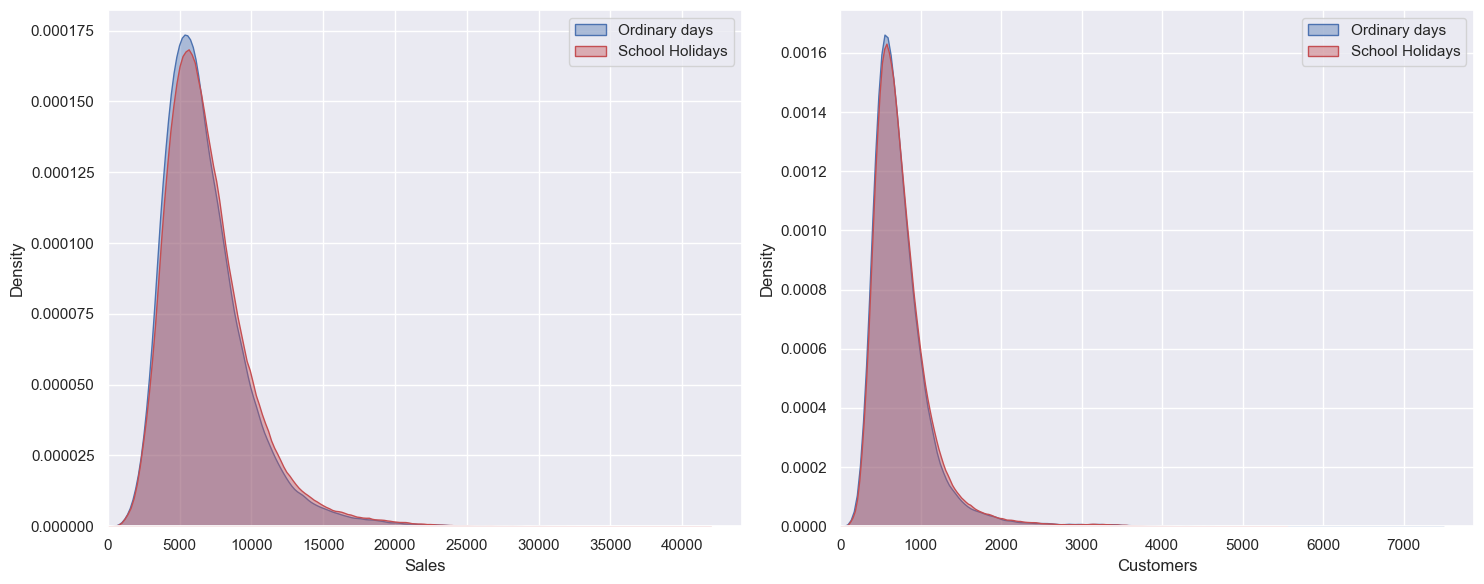

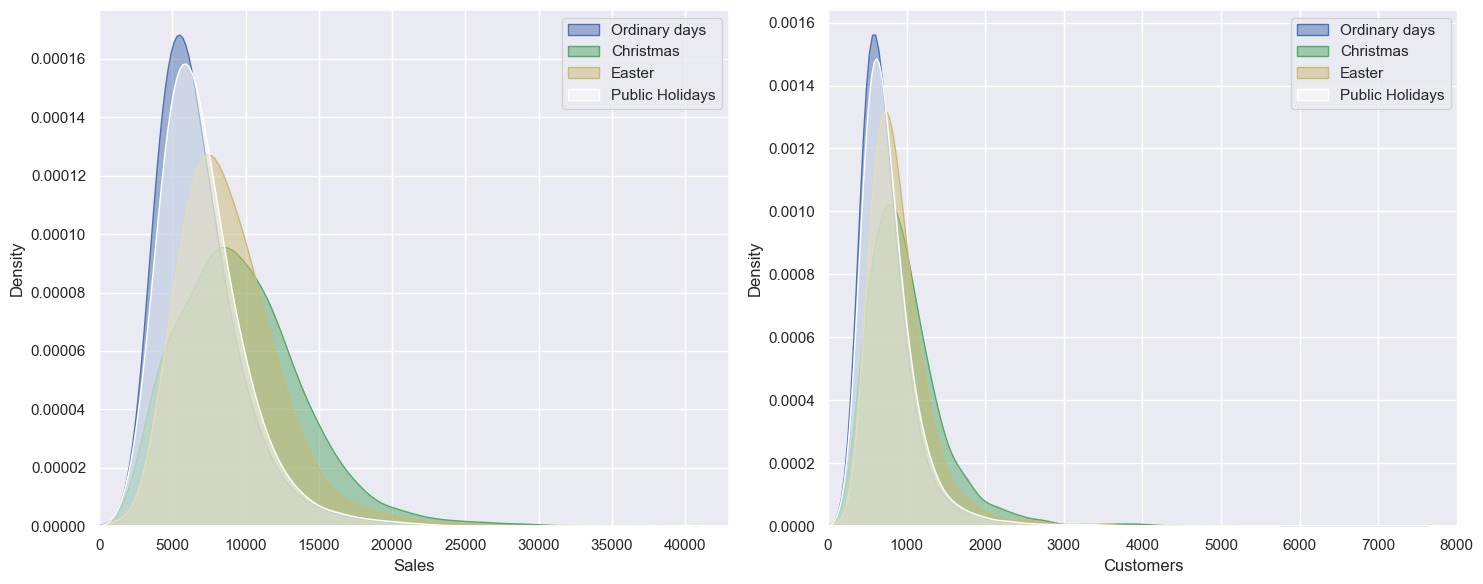

In [115]:
plt.figure(figsize=(15, 6))

cols = ['Sales', 'Customers']

for i, column in enumerate(cols, 1):
  plt.subplot(1, 2, i)
  sns.kdeplot(working_days[column], label='Ordinary days', fill=True, color='b', alpha=0.4)
  sns.kdeplot(school_holidays[column], label='School Holidays', fill=True, color='r', alpha=0.4)  
  plt.xlabel(f"{column}")
  plt.legend()
  plt.xlim(0, )


plt.tight_layout()
plt.show()

plt.figure(figsize=(15, 6))

cols = ['Sales', 'Customers']

for i, column in enumerate(cols, 1):
  plt.subplot(1, 2, i)

  sns.kdeplot(working_days[column], label='Ordinary days', fill=True, color='b', alpha=0.5, bw_method=0.2) 
  sns.kdeplot(christmas[column], label='Christmas', fill=True, color='g', alpha=0.5, bw_method=0.2)
  sns.kdeplot(easter[column], label='Easter', fill=True, color='y', alpha=0.5, bw_method=0.2)
  sns.kdeplot(public[column], label='Public Holidays', fill=True, color='w', alpha=0.5, bw_method=0.2)
  plt.xlabel(f"{column}")
  plt.legend()
  plt.xlim(0, )


plt.tight_layout()
plt.show()

**Based on the charts, ordinary days and school holidays exhibit similar density distributions, both closely resembling a bell-shaped curve. In contrast, Christmas, Easter, and public holidays contribute significantly to the outliers observed in the data.**

In [303]:
def sales_stats_count(df):    
     stats_count = df.agg(mean_sales = ('Sales', 'mean'),
                    median_sales = ('Sales', 'median'),
                    max_sales = ('Sales', 'max'),
                    percentile_25 = ('Sales', lambda x: x.quantile(0.25)),
                    percentile_75 = ('Sales', lambda x: x.quantile(0.75))
                    )
     return stats_count

holidays_vs_ordinary_sales = pd.merge(sales_stats_count(main_holidays),sales_stats_count(working_days), how='inner', left_index=True, right_index=True, suffixes=('_holidays', '_ordinary'))
holidays_vs_ordinary_sales

,Sales_holidays,Sales_ordinary
mean_sales,7670.755801,6796.090211
median_sales,7069.000000,6213.000000
max_sales,38722.000000,41551.000000
percentile_25,5356.000000,4767.250000
percentile_75,9283.750000,8134.000000


**The sales data for holidays and ordinary days shows distinct patterns in terms of central tendency and distribution.**

**Mean Sales:** The average sales for holidays are notably higher than for ordinary days , indicating that sales tend to be higher during holiday periods.

**Median Sales:** The median sales for holidays are also higher compared to ordinary days, which suggests that the typical sale value is higher during holidays, supporting the mean comparison.

**25th Percentile:** The lower quartile (25th percentile) for sales is higher during holidays compared to ordinary days , indicating a marginally lower frequency of low-value sales in holiday periods.

**75th Percentile:** The upper quartile (75th percentile) shows a significant difference, with holiday sales being higher than ordinary day sales, which further supports the higher sales overall during holidays, especially for the higher-end of the distribution.

These findings suggest that while holiday periods tend to boost sales across most of the distribution, there are still notable differences in the extremes, where ordinary days might have some high-outlier values. This could reflect specific promotional or sales events that occur on ordinary days.

## Anlysis of Promotion impact

### Percentage Distribution of Promo Types

In [56]:
def assign_promo_type(row):
    promo_types = []
    if row['Promo'] == 1:
        promo_types.append('Promo')
    if row['Promo2'] == 1:
        promo_types.append('Promo2')
    return '+'.join(promo_types) if promo_types else 'No Promo'

In [57]:
# New Promo_Type column creation
df['Promo_Type'] = df.apply(assign_promo_type, axis=1)

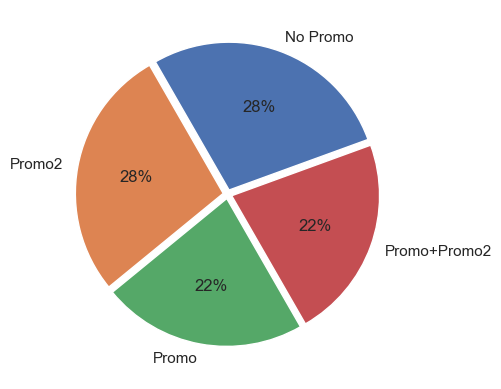

In [58]:
df['Promo_Type'].value_counts().plot(kind='pie', autopct='%1.0f%%', startangle=20, explode=(0.03, 0.03, 0.03, 0.03))
plt.ylabel('')
plt.show()

### Average Sales and Customer Counts by Promotion Type

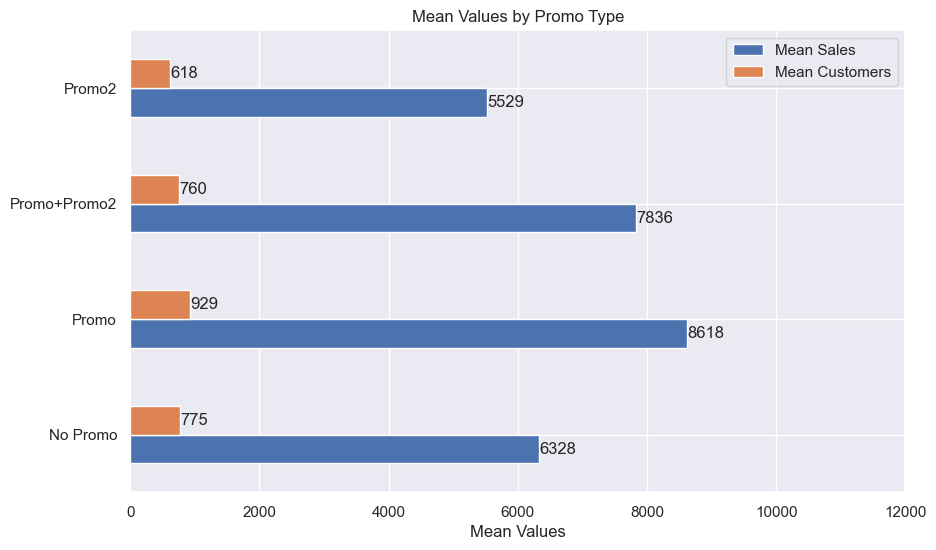

In [59]:
ax = df.groupby(['Promo_Type'])[['Sales', 'Customers']].mean().plot(kind='barh', figsize=(10, 6))
ax.legend(['Mean Sales', 'Mean Customers'])
# Annotate bars with mean values
for container in ax.containers:
    for bar in container:
        # Get bar coordinates
        width = bar.get_width()
        height = bar.get_height()
        xpos = width + 0.5  # Add spacing for text placement
        ypos = bar.get_y() + height / 2  # Center the text vertically
        # Add text
        ax.text(xpos, ypos, f'{width:.0f}', va='center')

# Show the plot
plt.title('Mean Values by Promo Type')
plt.xlabel('Mean Values')
ax.set_xlim(0, 12000)
plt.ylabel('')
plt.show()

**The Promo and Promo+Promo2 groups exhibit higher mean sales, with values of 8618 and 7836, respectively. In comparison, the mean sales for Promo2 and No Promo groups are 5529 and 6328, respectively. A similar pattern is observed in the mean number of customers. Notably, the Promo2 group shows mean statistics nearly identical to those of the No Promo group. However, given that Promo2 is implemented at the start of each quarter, it is likely to drive sales during specific periods following its initiation. This trend will be illustrated in the subsequent graph.**

### Investigating the Impact of Promo 2 Over Time

In [60]:
# Filter the dataset for Promo2
df_promo2 = df[df['Promo_Type'] == 'Promo2'].copy()

# Calculate the mean sales grouped by PromoStartMonth
mean_sales = df_promo2.groupby(['PromoStartMonth1', 'PromoStartMonth2', 'PromoStartMonth3', 'PromoStartMonth4'])[['Sales', 'Customers']].mean()
mean_sales = mean_sales.reset_index()
mean_sales 

,PromoStartMonth1,PromoStartMonth2,PromoStartMonth3,PromoStartMonth4,Sales,Customers
0,1,4,7,10,5681.102347,632.844932
1,2,5,8,11,5354.413116,598.149306
2,3,6,9,12,5282.346669,598.382168


**For Promo2 promotion type:**

- The PromoStartMonth values progress in a pattern that suggests a systematic schedule, likely quarterly or staggered across different periods (e.g., campaigns starting in Q1, Q2, Q3, and Q4).

- Sales values show a slight decrease across the rows (5681.10 → 5354.41 → 5282.35), indicating: a potential downward trend in sales or seasonal effects or market saturation over time.

In [61]:
def plot_roliing_average_with_highlighted_PromoStartMonths(data, strategy_num, window):
    with sns.axes_style("white"):    
        # -------------------------------------------------------rolling average data----------------------------------------
        sales = data.groupby(['Date'])['Sales'].mean().rolling(window=window, min_periods=1).mean()
        customers = data.groupby(['Date'])['Customers'].mean().rolling(window=window, min_periods=1).mean()
        plt.figure(figsize=(12,7), dpi=120)      
  
        #---------------------------------------------------------- PLot / Axis settings----------------------------------
        plt.xticks(ticks=np.arange(2013, 2016, step=1), fontsize=10, rotation=60)
         
        ax1 = plt.gca()
        ax1.set_xlim([sales.index.min(), sales.index.max()])
        
        # Apply the locators and formatters
        months = mdates.MonthLocator()  # Locator for months
        months_fmt = mdates.DateFormatter('%b %Y')  # Formatter for months and year
        ax1.xaxis.set_major_locator(months)  # Place a tick for every month
        ax1.xaxis.set_major_formatter(months_fmt) 
        
        
        # ---------------------------------------------------------------Plot Data-----------------------------------------
        ax1.plot(sales.index, 
                 sales.values, 
                 color='#00539CFF', linewidth=2, linestyle='-')
        ax1.set_ylabel('Sales', color='#00539CFF', fontsize=14)
        ax1.set_ylim(0, 12000)
        
        ax2 = ax1.twinx()
        
        ax2.plot(customers.index, 
                 customers.values, 
                 color='#EEA47FFF', linewidth=2, linestyle='-')
        ax2.set_ylabel('Customers', color='#EEA47FFF', fontsize=14)
        ax2.set_ylim(0, 1400)
   
        
        # -----------------------------------------------------Highlight specific months---------------------------------
        highlight_months = [m for n in range(1, 5) for m in data[f'PromoStartMonth{n}'].unique()]  # Months to underline
        highlight_years = [y for y in data['Year'].unique()] 
        
        for year in highlight_years:
            for month in highlight_months:
                start_date = pd.to_datetime(f'{year}-{month:02d}-01')
                end_date = pd.to_datetime(f'{year}-{month:02d}-28')  
                y_min, y_max = ax1.get_ylim()
                text_y = y_max * 0.83  
        
                # Highlight Promo2
                ax1.axvspan(start_date, end_date, color='#B0A695', alpha=0.2, label=f'Highlight Month {month}')                
                specific_date = end_date - pd.Timedelta(days=15)
                if specific_date < pd.to_datetime('2015-07-30'):
                    ax1.text(specific_date, text_y, 'Promo2 start', color='grey', fontsize=10, ha='center', va='bottom', rotation=90)
        
                # Highlight Christmas periods
                ax1.axvspan(pd.to_datetime(f'{year}-12-01'), pd.to_datetime(f'{year}-12-31'), color='#CDC1FF', alpha=0.2, label='Christmas')        
                specific_date = pd.to_datetime(f'{year}-12-15')
                if specific_date < pd.to_datetime('2015-07-30'):
                    ax1.text(specific_date, y_max * 0.2, 'Christmas', color='grey', fontsize=10, ha='center', va='bottom', rotation=90)


        
        plt.title(f'Sales and Customers ({window}-Day Rolling Average)\n\nTrend with Highlighted PromoStartMonths (Strategy{strategy}) for PROMO2 Shops', fontsize=12)
        plt.tight_layout()
        plt.show()
        

In [62]:
df_promo2_group1 = df_promo2[(df_promo2['PromoStartMonth1'] == 1)]
df_promo2_group2 = df_promo2[(df_promo2['PromoStartMonth1'] == 2)]
df_promo2_group3 = df_promo2[(df_promo2['PromoStartMonth1'] == 3)]

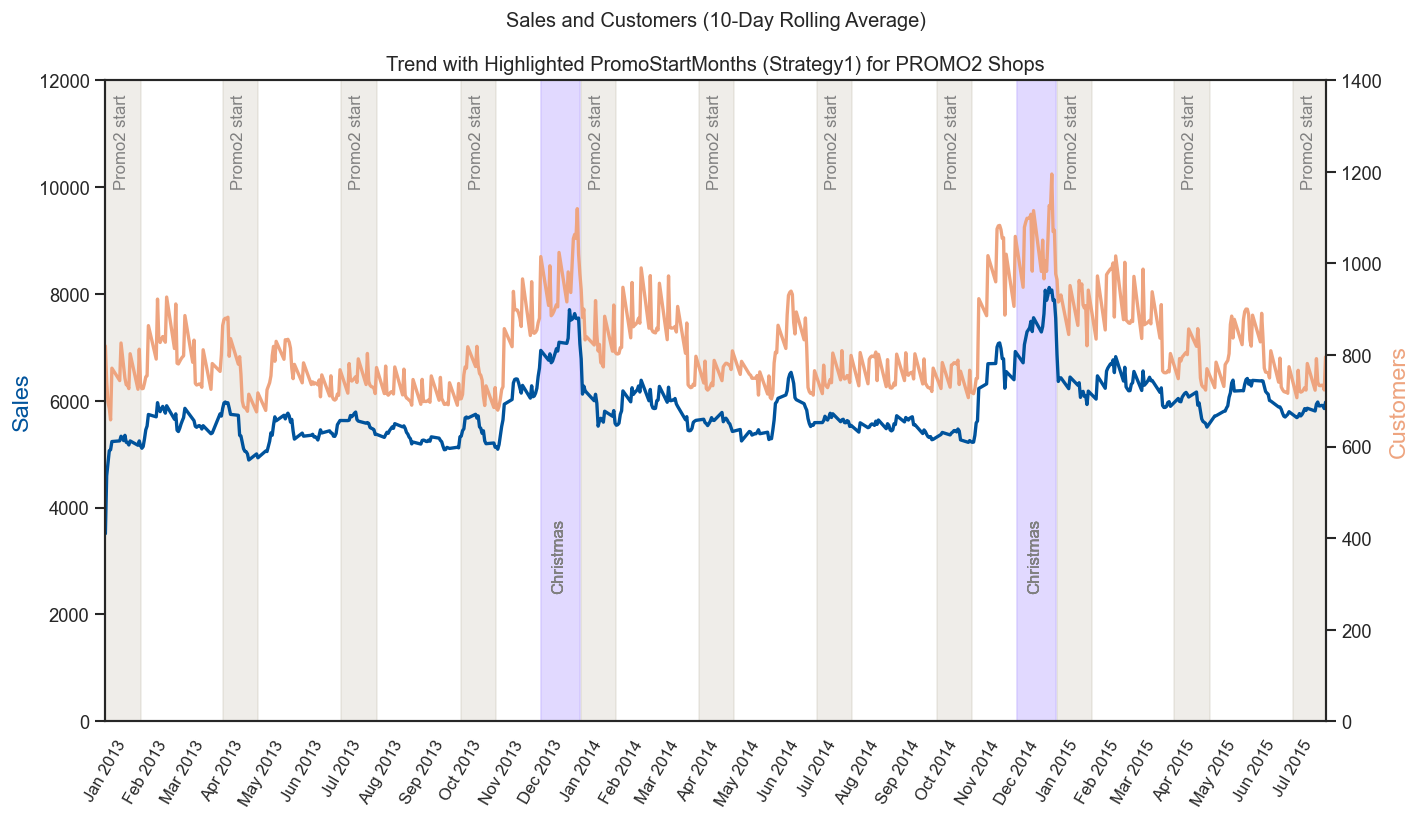

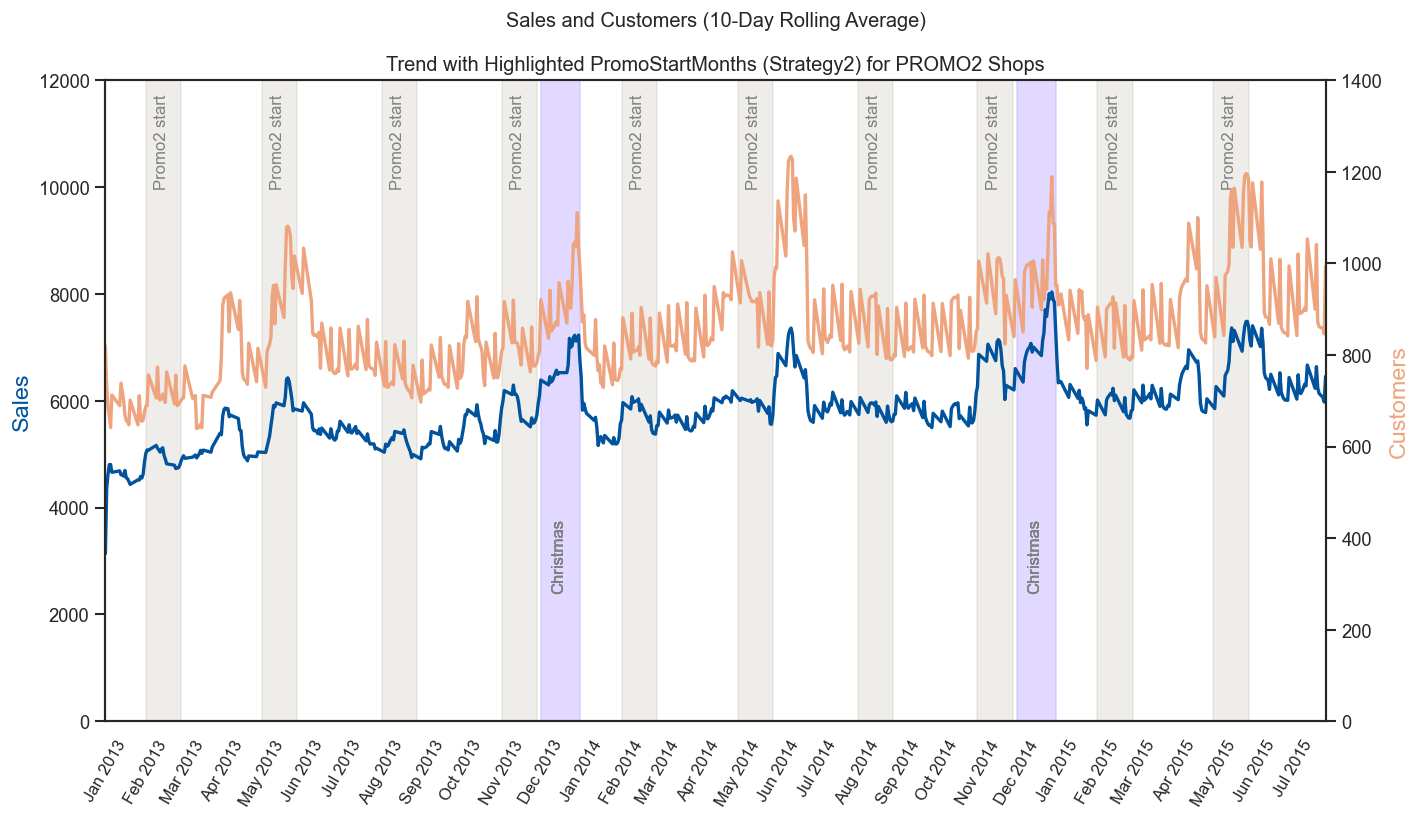

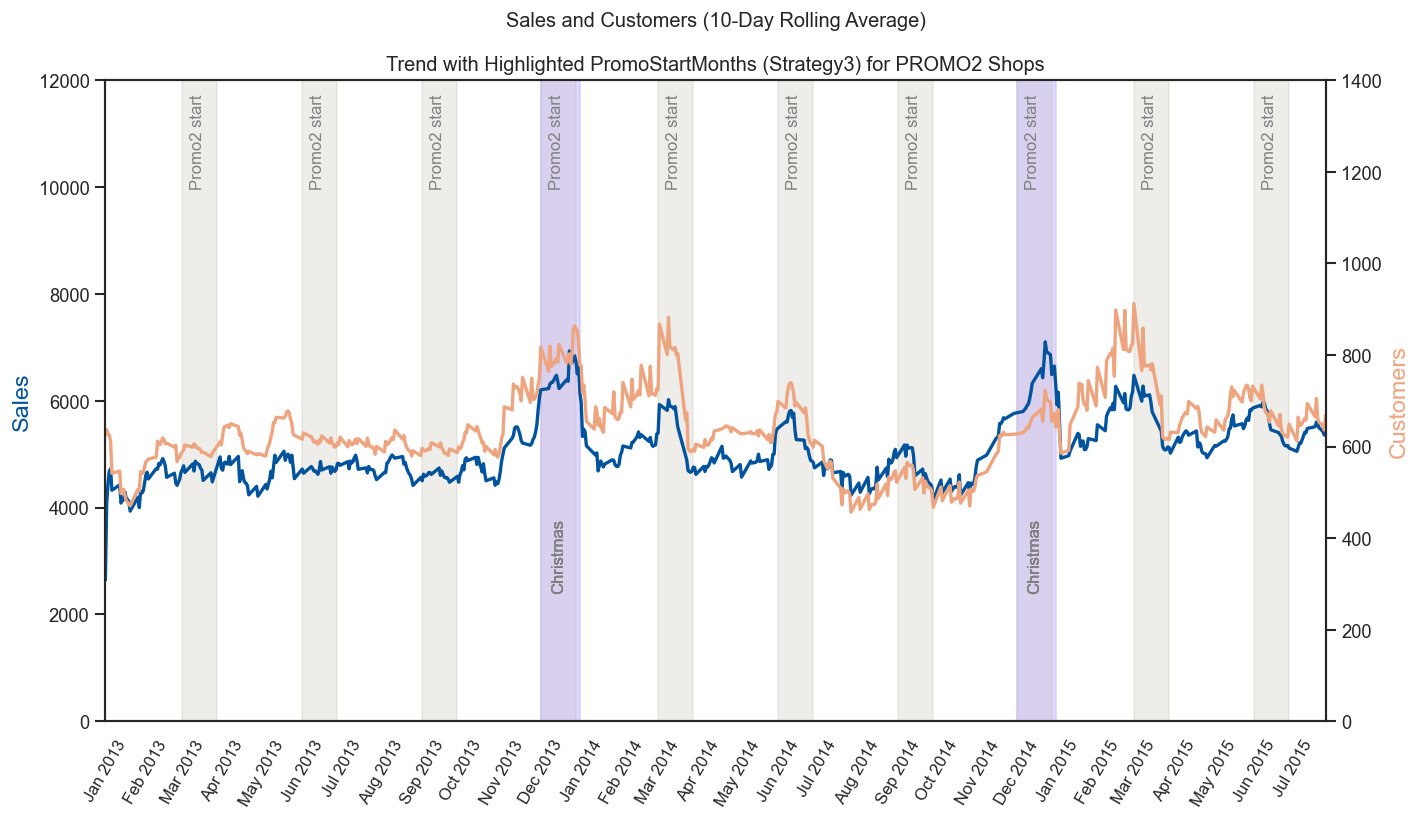

In [63]:
dataframes = [df_promo2_group1, df_promo2_group2, df_promo2_group3]
strategy = 1

for data_promo in dataframes:
    plot_roliing_average_with_highlighted_PromoStartMonths(data_promo, strategy, 10)
    strategy += 1

**There is no clear pattern observed. While some promotions are associated with an increase in sales, this effect is not consistent across all instances. A more defined trend may emerge when analyzing the combined data from Promo and Promo2.**

### Investigating the Impact of Promo+Promo2 Over Time

In [64]:
# Filter the dataset for Promo+Promo2
df_promo_promo2 = df[df['Promo_Type'] == 'Promo+Promo2'].copy()

# Calculate the mean sales grouped by PromoStartMonth
mean_sales = df_promo_promo2.groupby(['PromoStartMonth1', 'PromoStartMonth2', 'PromoStartMonth3', 'PromoStartMonth4'])[['Sales', 'Customers']].mean()
mean_sales = mean_sales.reset_index()
mean_sales 

,PromoStartMonth1,PromoStartMonth2,PromoStartMonth3,PromoStartMonth4,Sales,Customers
0,1,4,7,10,8027.093047,775.537748
1,2,5,8,11,7751.937365,747.340526
2,3,6,9,12,7366.723390,727.785952


**For Promo+Promo2 promotion type:**

- Sales range from 8027.09 to 7366.72, significantly higher than in Promo2.
- Customers range from 775.54 to 727.79, also higher than in Promo2.
- There is a clear decline in sales over the rows (8027.09 → 7751.94 → 7366.72), similar to the in Promo2. This pattern could again reflect: seasonality, competition, or reduced promo effectiveness over time.
- Customers: The number of customers decreases slightly (775.54 → 747.34 → 727.79), though the decline is more pronounced compared to Promo2 type.

In [65]:
df_promo12_group1 = df_promo_promo2[(df_promo_promo2['PromoStartMonth1'] == 1)]
df_promo12_group2 = df_promo_promo2[(df_promo_promo2['PromoStartMonth1'] == 2)]
df_promo12_group3 = df_promo_promo2[(df_promo_promo2['PromoStartMonth1'] == 3)]

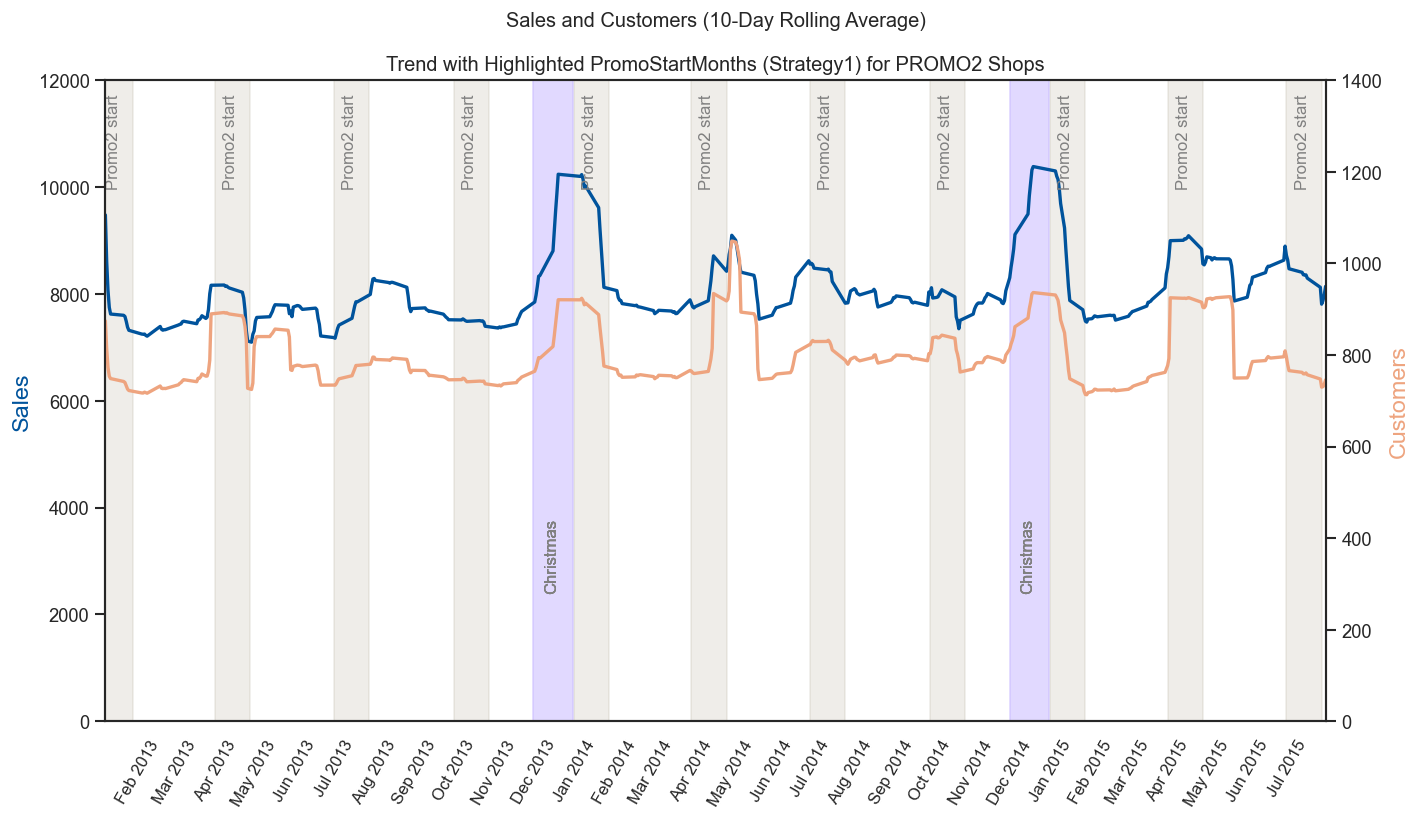

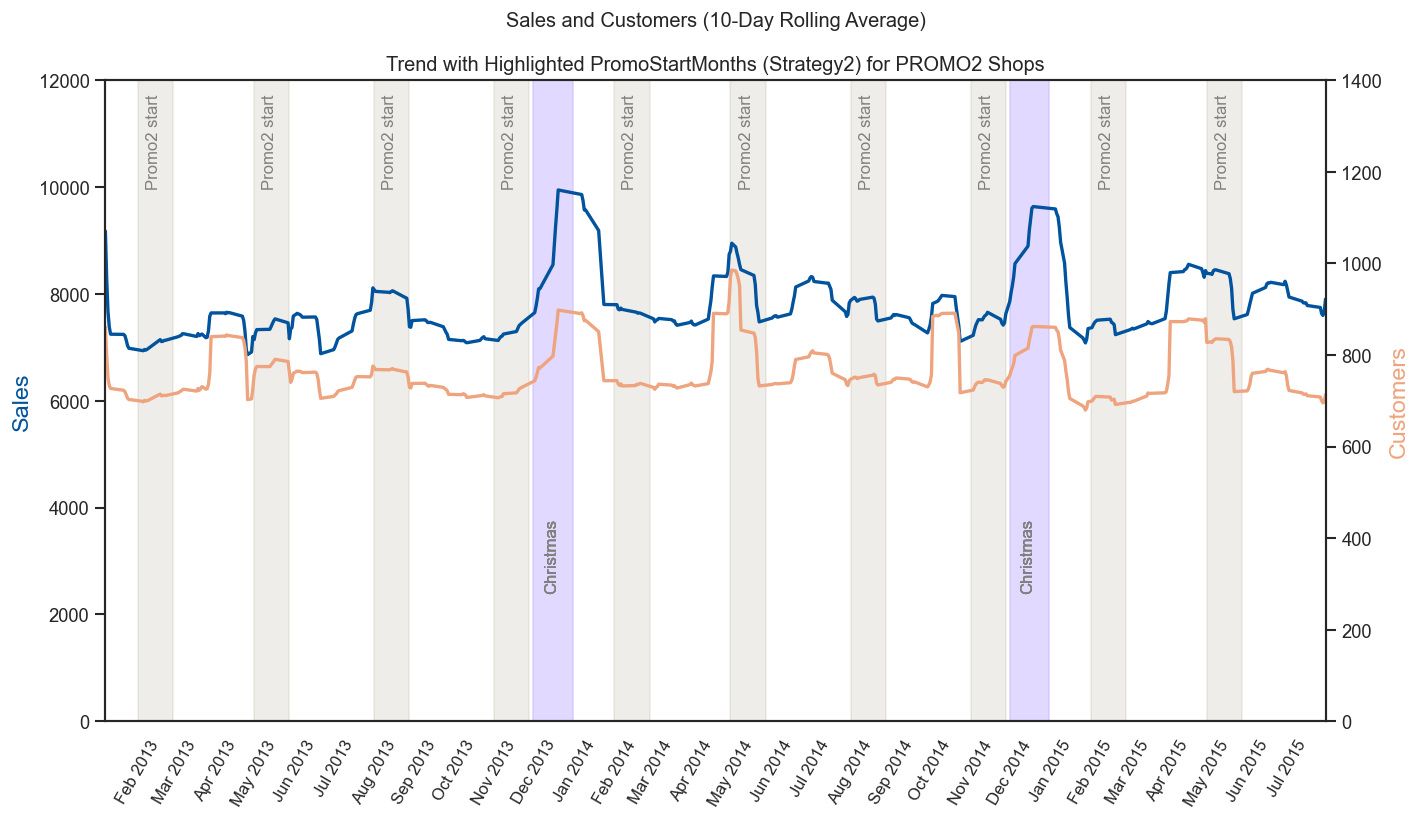

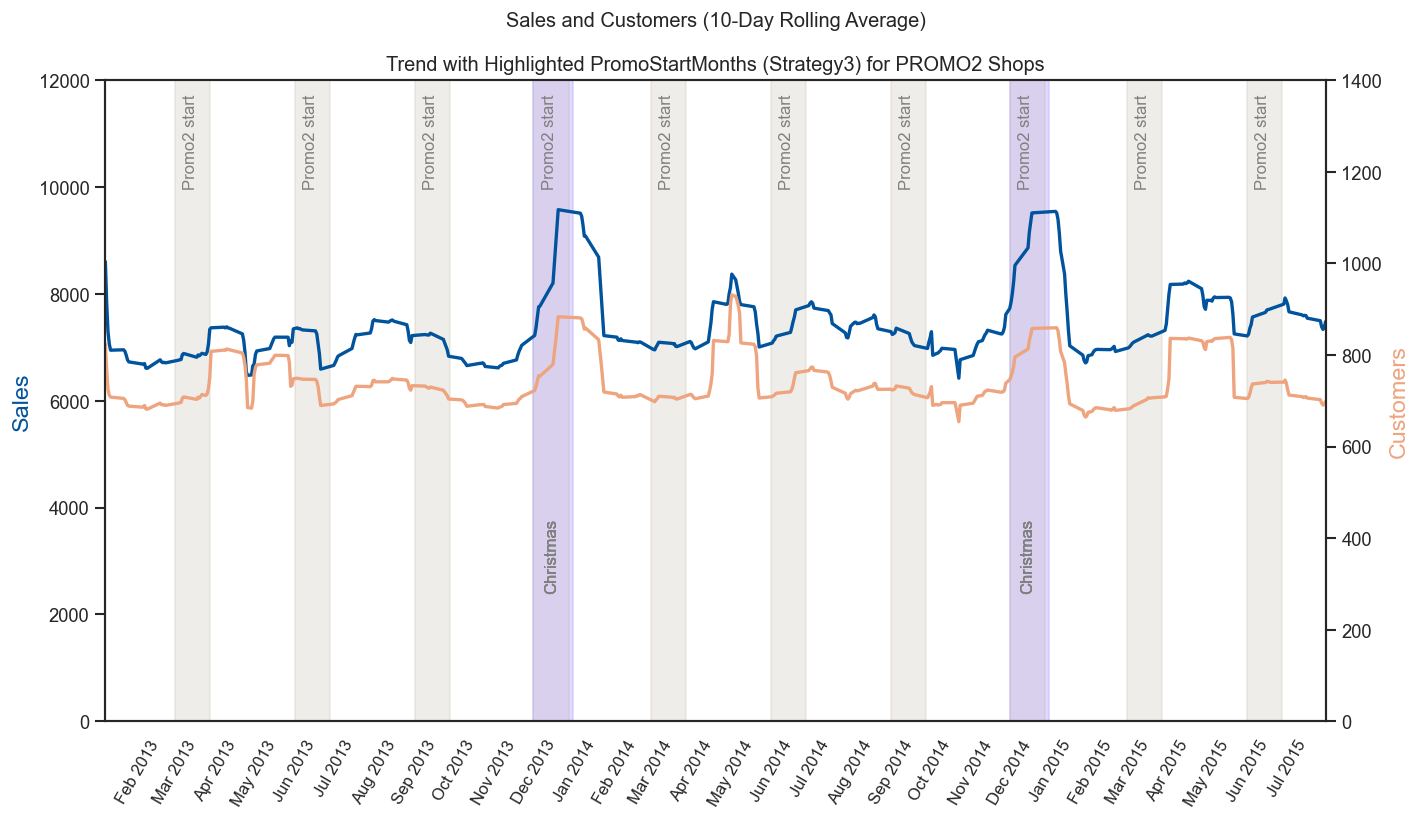

In [66]:
dataframes2 = [df_promo12_group1, df_promo12_group2, df_promo12_group3]
strategy = 1

for promo12_data in dataframes2:    
    plot_roliing_average_with_highlighted_PromoStartMonths(promo12_data, strategy, 10)
    strategy += 1

**Overall, the Promo+Promo2 strategy demonstrates higher sales, typically ranging between 6000 and 8000 (whereas Promo2 alone ranges from 4000 to 8000). There appears to be a slight increase in sales and customers during the April-June (probably Easter time) period each year, although this trend does not consistently follow Promo actions. Overall, there is no clear trend related to the start periods of Promo2 campaigns.**

## Competition Distance Analysis

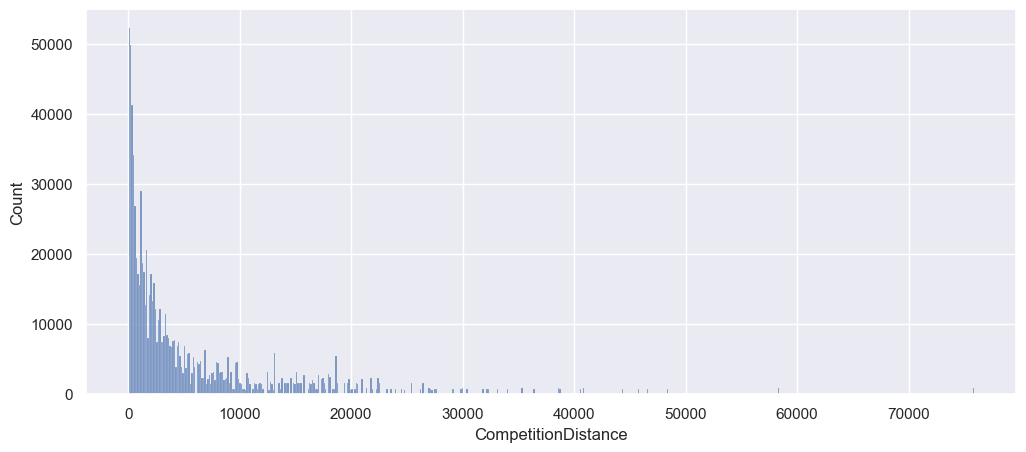

In [67]:
plt.figure(figsize = (12,5))
sns.histplot(df['CompetitionDistance'])
plt.show()

In [68]:
# create ranges for CompetitionDistance and assign labels like Close, Medium, and Far
def categorize_distance(distance):
    if distance <= 5000:
        return 'Nearby'
    elif distance <= 15000:
        return 'Moderate'
    else:
        return 'Distant'

In [69]:
df.loc[:, 'CompetitionDistanceType'] = df['CompetitionDistance'].apply(categorize_distance)

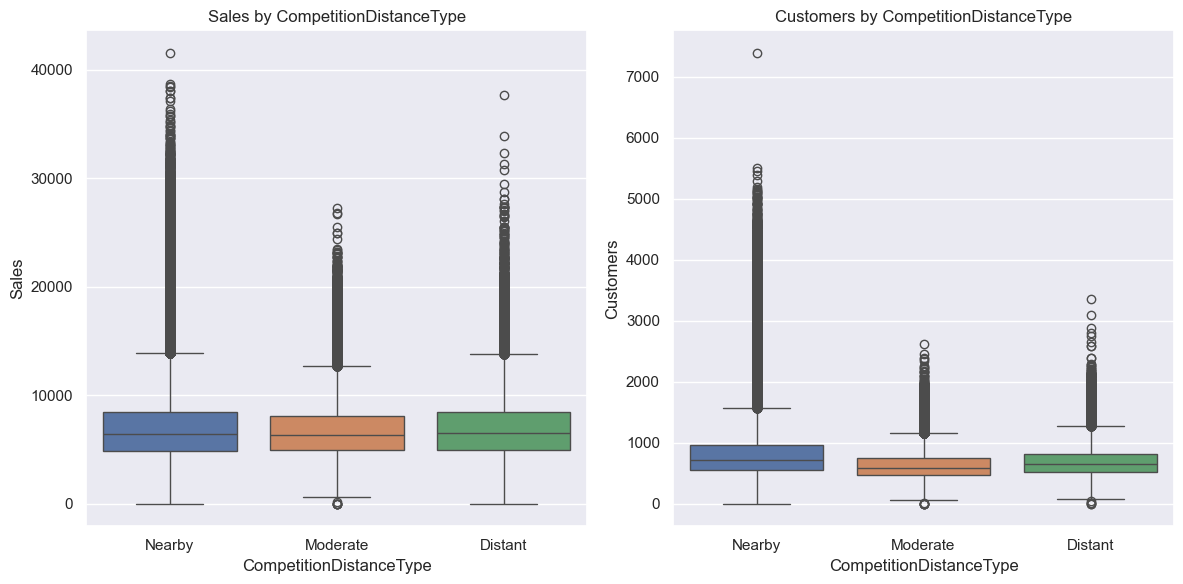

In [70]:
# Boxplots for visual comparison
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
sns.boxplot(data=df, x='CompetitionDistanceType', y='Sales', ax=axes[0], hue='CompetitionDistanceType')
axes[0].set_title('Sales by CompetitionDistanceType')

sns.boxplot(data=df, x='CompetitionDistanceType', y='Customers', ax=axes[1], hue='CompetitionDistanceType')
axes[1].set_title('Customers by CompetitionDistanceType')
plt.tight_layout()
plt.show()

In [71]:
df.groupby(['CompetitionDistanceType']).agg(Sales_mean=('Sales', lambda x: round(x.mean(), 2)),
                                            Customers_mean=('Customers', lambda x: round(x.mean(), 2)))

,Sales_mean,Customers_mean
CompetitionDistanceType,,
Distant,6931.62,685.84
Moderate,6692.10,623.40
Nearby,7038.30,816.93


**Overall, CompetitionDistance doesn't have a significant impact on sales or the number of customers in stores, though some minor differences can still be observed.**

**Sales Mean:**

- Nearby stores have the highest average sales (7038.30), followed by Distant stores (6931.62), and Moderate distance stores (6692.10).
- This suggests that stores located nearby competing stores have the highest sales on average, likely due to increased customer foot traffic and awareness.
- Moderate distance stores have the lowest average sales, which might indicate a less favorable location in terms of competition proximity.

**Customers Mean:**

- Nearby stores also attract the highest number of customers on average (816.93), followed by Distant stores (685.84), and Moderate distance stores (623.40).
- Stores that are nearby competitors seem to attract more customers, possibly due to easier accessibility and proximity.
- Moderate distance stores have the fewest customers, which may reflect reduced accessibility or a less attractive location compared to nearby or distant stores.

## Assortment: A Comparative Analysis

### Assortment EDA

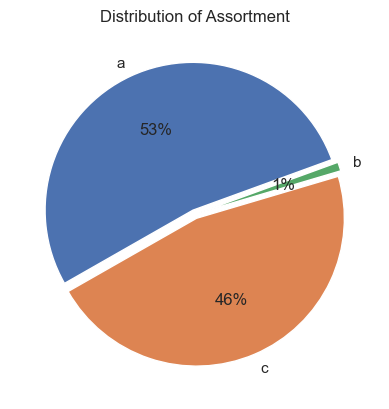

In [72]:
# Plot pie chart with actual numbers
df['Assortment'].value_counts().plot(kind='pie', autopct='%1.0f%%', startangle=20, explode=(0.03, 0.03, 0.03))

# Add title (optional)
plt.title('Distribution of Assortment')
plt.ylabel('')

# Display the plot
plt.show()

In [73]:
df['Assortment'].value_counts()

Assortment
a    444909
c    391271
b      8212
Name: count, dtype: int64

**Thus, 53% of the stores have an "a" (basic) assortment, 46% have a "c" (extended) assortment, and only 1% of the stores have a "b" (extra) assortment.**

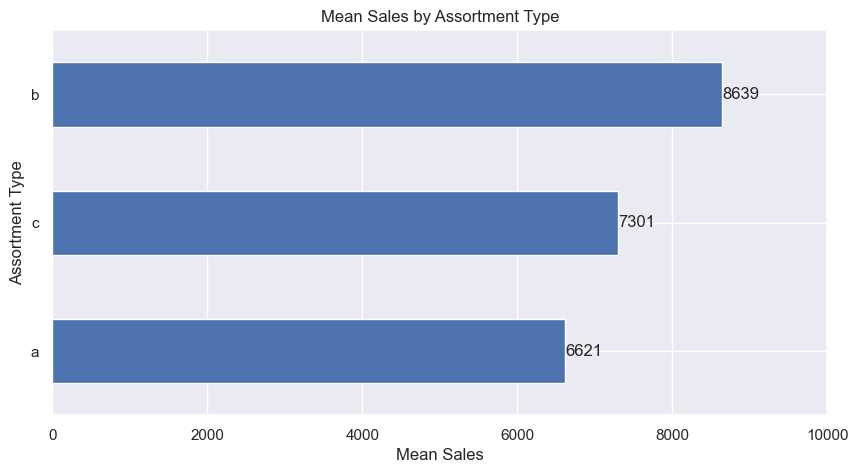

In [74]:
plt.figure(figsize=(10,5))
ax = df.groupby(['Assortment'])["Sales"].mean().sort_values().plot(kind='barh')

for container in ax.containers:
    for bar in container:
        # Get bar coordinates
        width = bar.get_width()
        height = bar.get_height()
        xpos = width + 0.5  # Add spacing for text placement
        ypos = bar.get_y() + height / 2  # Center the text vertically
        # Add text
        ax.text(xpos, ypos, f'{width:.0f}', va='center')

# Show the plot
plt.title('Mean Sales by Assortment Type')
plt.xlabel('Mean Sales')
plt.ylabel('Assortment Type')
ax.set_xlim(0, 10000)
plt.show()

### Data Sampling

**Let's take a random sample of 8,000 stores from each group (Assortment "a", "b", and "c") and perform ANOVA, keeping in mind the Central Limit Theorem (CLT). According to the CLT, with a sufficiently large sample size, the distribution of the sample mean will approximate a normal distribution, even if the underlying population distribution is not normal.**

In [75]:
a = df[df['Assortment']=='a']['Sales'].sample(8000, random_state=42)
b = df[df['Assortment']=='b']['Sales'].sample(8000, random_state=42)
c = df[df['Assortment']=='c']['Sales'].sample(8000, random_state=42)

df_samples_combined = pd.DataFrame({
    'Sales': pd.concat([a, b, c]),
    'Assortment': ['a'] * len(a) + ['b'] * len(b) + ['c'] * len(c)
})

### Comparison of Original and Sample Data Distributions

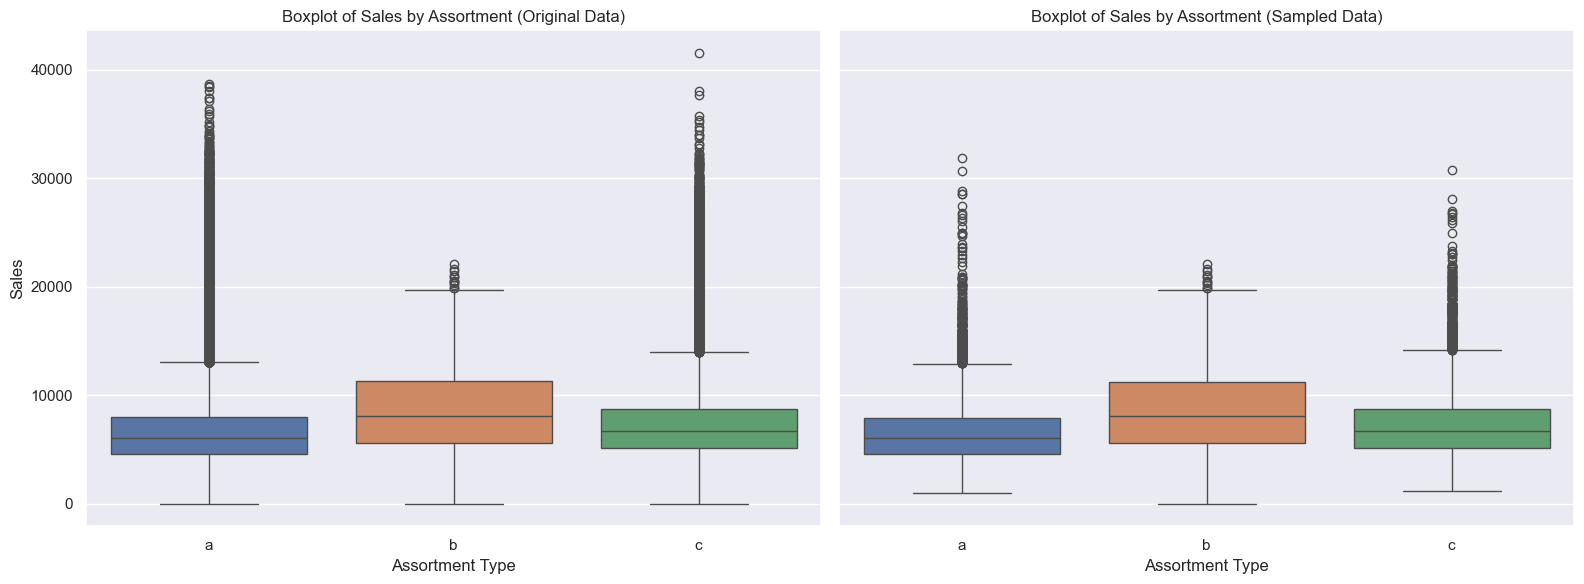

In [76]:
assortment_order = ['a', 'b', 'c']
fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharey=True)

# First boxplot: Original data
sns.boxplot(ax=axes[0], x='Assortment', y='Sales', data=df,  order=assortment_order, hue='Assortment', hue_order=assortment_order)
axes[0].set_title("Boxplot of Sales by Assortment (Original Data)")
axes[0].set_xlabel("Assortment Type")
axes[0].set_ylabel("Sales")

# Second boxplot: Sampled data
sns.boxplot(ax=axes[1], x='Assortment', y='Sales', data=df_samples_combined, order=assortment_order, hue='Assortment', hue_order=assortment_order)
axes[1].set_title("Boxplot of Sales by Assortment (Sampled Data)")
axes[1].set_xlabel("Assortment Type")
axes[1].set_ylabel("Sales")

# Adjust layout
plt.tight_layout()
plt.show()

**The boxplots for the original data and the sampled data exhibit similar distributions. The medians (central lines in the boxes) and interquartile ranges (IQRs) are visually similar between the two datasets, it suggests that the central tendency and spread of sales data have been preserved during sampling**

### Levene test

In [77]:
stat, p_value = stats.levene(a, b, c)
print(f'Levene’s test for equality of variances: p-value = {p_value}')

Levene’s test for equality of variances: p-value = 8.023237005261192e-203


**The p-value is extremely small, so we reject the null hypothesis. This indicates that there are significant differences in variance between the groups. I will use Welch's ANOVA, which does not assume equal variances and is robust to variance heterogeneity.**

### Welch ANOVA

In [78]:
# Perform Welch ANOVA
welch_anova = pg.welch_anova(dv='Sales', between='Assortment', data=df_samples_combined)

print(welch_anova)

       Source  ddof1         ddof2           F          p-unc       np2
0  Assortment      2  15855.751542  704.910107  5.189316e-294  0.059704


**Reject Null Hypothesis:**

The p-value confirms that the mean sales differ significantly among the assortment types (a, b, and c).

**Effect Size:**

While statistically significant, the effect size (5.97%) suggests that assortment type explains only a small portion of the variability in sales. Other factors likely contribute to sales differences.

**To identify which pairs of assortment types differ significantly let's perform post-hoc tests**

### Games-Howell test

In [79]:
## Perform Games-Howell test
posthoc_test = pg.pairwise_gameshowell(dv='Sales', between='Assortment', data=df_samples_combined)
posthoc_test

,A,B,mean(A),mean(B),diff,se,T,df,pval,hedges
0,a,b,6608.740375,8635.953500,-2027.213125,54.094157,-37.475640,15171.953129,5.033751e-13,-0.592514
1,a,c,6608.740375,7282.348625,-673.608250,48.917539,-13.770281,15935.773846,9.897749e-12,-0.217717
2,b,c,8635.953500,7282.348625,1353.604875,55.459066,24.407278,15531.148737,3.289369e-12,0.385895


### Conclusions

**Statistical Significance:**

- All pairwise comparisons are statistically significant (p-values < 0.05), likely influenced by the large sample size.

**Effect Sizes:**

- The largest effect size is observed between groups a and b (|Hedges' g| = 0.59), indicating a moderate effect size. This suggests that the difference in sales between these groups is noticeable and likely to have practical importance.
- The effect size between a and c (|Hedges' g| = 0.22) is smaller but still reflects a statistically significant difference.
- The effect size between b and c (|Hedges' g| = 0.39) indicates a medium effect size, suggesting a moderate difference in sales performance.

**Practical Insights:**

- Stores with an "extra" (b) assortment consistently achieve significantly higher sales compared to both "basic" (a) and "extended" (c) assortments.
- While "extended" (c) assortments outperform "basic" (a) assortments, they do not reach the performance levels of "extra" (b) assortments.

## Store Type Sales Performance: A Comparative Analysis

### Store Type Sales EDA

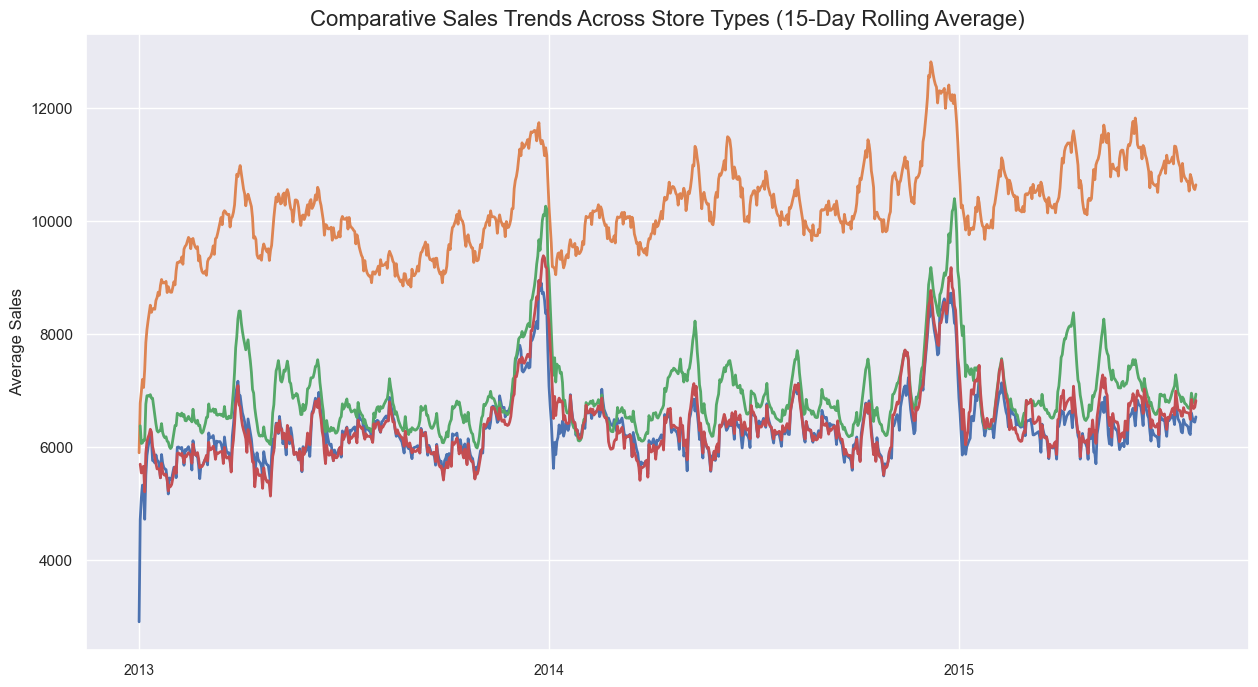

In [80]:
window = 15
store_type_sales = df.groupby(['Date', 'StoreType'])['Sales'].mean().unstack().rolling(window=window, min_periods=1).mean()

plt.figure(figsize=(15, 8))
ax = plt.gca()
        
# Apply the locators and formatters
ax.xaxis.set_major_locator(years)
ax.xaxis.set_major_formatter(years_fmt)
ax.xaxis.set_minor_locator(months)

# Enable minor ticks
ax.minorticks_on()
  

# Plot Data
ax.plot(pd.to_datetime(store_type_sales.index), 
         store_type_sales.values, 
         linewidth=2, linestyle='-')
ax.tick_params(axis='x', labelsize=10)
plt.title(f'Comparative Sales Trends Across Store Types ({window}-Day Rolling Average)', fontsize = 16)
plt.ylabel('Average Sales')
plt.show()

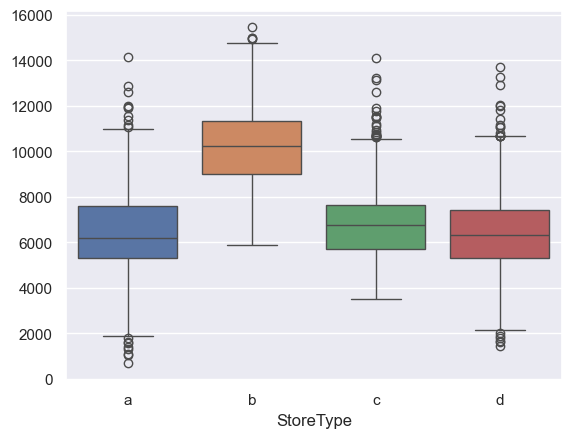

In [81]:
sales_by_store = df.groupby(['Date', 'StoreType'])['Sales'].mean().unstack()
sns.boxplot(sales_by_store)
plt.show()

In [82]:
result = df.groupby('StoreType').agg(mean_sales=('Sales', 'mean'),
                                     median_sales=('Sales', 'median')).reset_index()
result

,StoreType,mean_sales,median_sales
0,a,6925.167661,6285.0
1,b,10231.407505,9130.0
2,c,6932.512755,6407.0
3,d,6822.141881,6395.0


**Store Type B exhibits the highest sales among all types, with both the mean and median values substantially higher than those of other store types, suggesting better overall sales performance. Let's check if there is a significant difference between  store types.**

### Data distribution

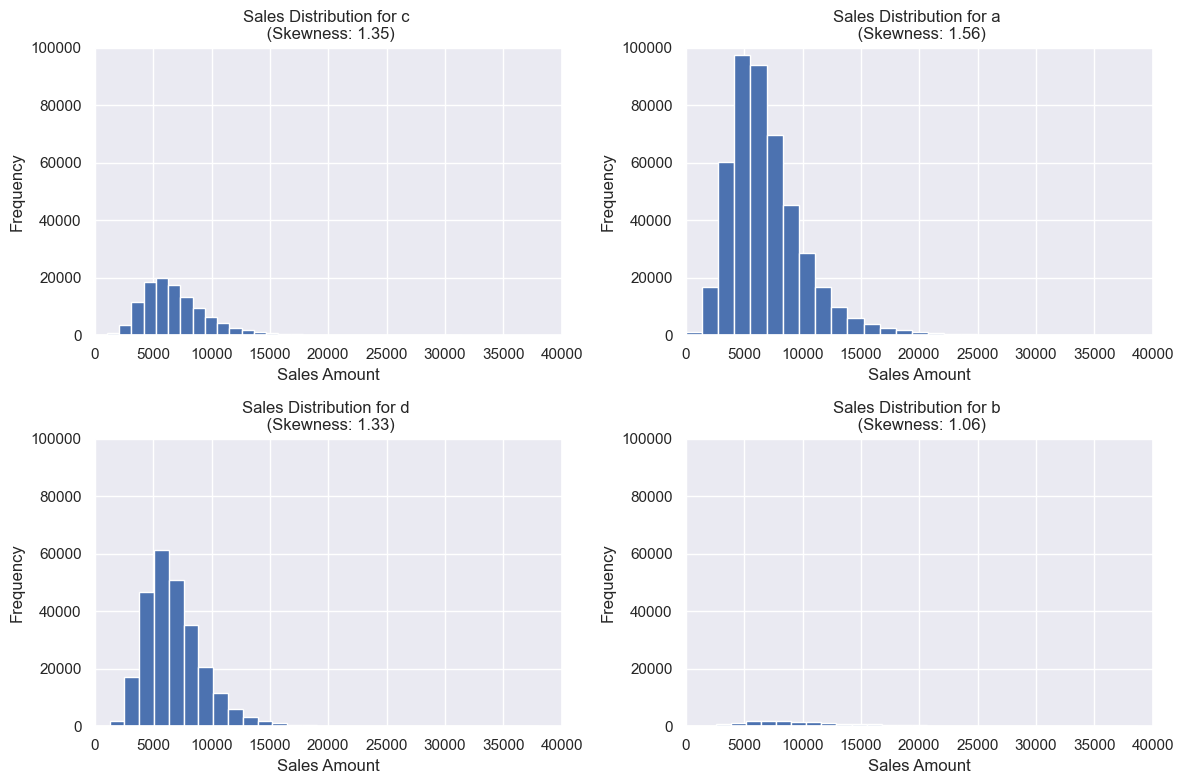

In [83]:
store_types = df['StoreType'].unique()

# Create subplots
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 8))
axes = axes.flatten()

# Loop through each store type and calculate skewness
for i, store_type in enumerate(store_types):
    store_data = df[df['StoreType'] == store_type]['Sales']

    # Calculate skewness for the sales data of each store type
    skewness = store_data.skew()
    
    # Plot histogram
    axes[i].hist(store_data, bins=30)
    axes[i].set_title(f"Sales Distribution for {store_type} \n (Skewness: {skewness:.2f})")
    axes[i].set_xlabel('Sales Amount')
    axes[i].set_ylabel('Frequency')
    for ax in axes:
        ax.set_ylim(0, 100000)
        ax.set_xlim(0, 40000)
        # ax.set_yticks([x for x in range(0, 4400, 500)]) 



# Adjust layout
plt.tight_layout()
plt.show()

In [84]:
variance_ratios = df.groupby('StoreType')['Sales'].var().max() / df.groupby('StoreType')['Sales'].var().min()
print(f"Variance Ratio: {variance_ratios}")

Variance Ratio: 4.069176586172241


**The skewness values (1.06, 1.33, 1.35, and 1.56) indicate a moderate to high level of skewness, suggesting deviations from normality. However, due to the large sample size, we can assume that the sample means follow a normal distribution, justifying the use of parametric tests like ANOVA (Analysis of Variance). The histograms show that some groups exhibit wider spreads, and the high Variance Ratio (3.72) indicates significant differences in sales variability across store types, suggesting potential variance differences. Let's check homogeneity of variances using Levene's test**

### Levene test

In [85]:
# Checking homogeneity of variances using Levene's test
store_data_groups = [df[df['StoreType'] == store_type]['Sales'] for store_type in df['StoreType'].unique()]

levene_stat, levene_p_value = stats.levene(*store_data_groups)
print(f"Levene's test for homogeneity of variances: p-value = {levene_p_value}")

if levene_p_value < 0.05:
    print("Levene's test: Variances are significantly different (reject H₀)")
else:
    print("Levene's test: Variances are homogenous (fail to reject H₀)")
print('-' * 50)

Levene's test for homogeneity of variances: p-value = 0.0
Levene's test: Variances are significantly different (reject H₀)
--------------------------------------------------


In [86]:
subsample = df.sample(2000, random_state=42)
store_data_groups = [subsample[subsample['StoreType'] == store_type]['Sales'] for store_type in df['StoreType'].unique()]
stat, p_value = stats.levene(*store_data_groups)
print(f"Levene’s Test Stat for 2000 sample: {stat}, p-value: {p_value}")

Levene’s Test Stat for 2000 sample: 17.177364289822794, p-value: 5.1612379384855596e-11


**Levene's test indicates that the variances are unequal across all store types, as well as for a sample of 2000 data points. Therefore, we will use the Welch ANOVA test, which is more robust to unequal variances and can provide more reliable results in this case.**

### Welch’s ANOVA

**Null hypothesis (H₀):** The means of all groups are equal (i.e., there is no significant difference in the group means).

**Alternative hypothesis (H₁):** At least one group mean is different from the others.

In [87]:
# Perform Welch's ANOVA
import pingouin as pg

# Apply Welch's ANOVA
welch_anova = pg.welch_anova(dv='Sales', between='StoreType', data=df)

# Display the results
print(welch_anova)

      Source  ddof1        ddof2            F  p-unc       np2
0  StoreType      3  69400.74361  2257.910284    0.0  0.021151


- The Welch ANOVA test indicates that StoreType significantly influences the dependent variable (likely sales), as evidenced by the very low p-value.
- The np2 value of 0.0211 suggests that about 2.11% of the total variability in the data is explained by the differences between store types. While this suggests a statistically significant effect, the effect size is small, indicating that StoreType only accounts for a small portion of the variance in the data.

**Let's  perform post hoc test to determine which pairs of groups differ significantly**

### Games-Howell test

In [88]:
# Games-Howell test
import pingouin as pg

posthoc_results = pg.pairwise_gameshowell(dv='Sales', between='StoreType', data=df)

posthoc_results

,A,B,mean(A),mean(B),diff,se,T,df,pval,hedges
0,a,b,6925.167661,10231.407505,-3306.239844,41.622949,-79.433100,15992.930313,1.210787e-11,-0.985035
1,a,c,6925.167661,6932.512755,-7.345094,9.890396,-0.742649,191025.388096,8.798207e-01,-0.002291
2,a,d,6925.167661,6822.141881,103.025780,6.983097,14.753595,647194.144708,0.000000e+00,0.033925
3,b,c,10231.407505,6932.512755,3298.894750,42.228883,78.119395,16940.441324,9.466872e-12,1.013270
4,b,d,10231.407505,6822.141881,3409.265624,41.643994,81.866922,16025.192786,3.150591e-12,1.230684
5,c,d,6932.512755,6822.141881,110.370874,9.978592,11.060766,193087.250856,0.000000e+00,0.041418


**Groups with Significant Differences (p-value < 0.05):**

- a vs. b: The mean sales for a (6925.17) and b (10231.41) show a significant difference (p-value ~ 1.2e-11). The effect size (Hedges' g = -0.985) suggests a large difference between the two groups, with b having much higher sales.

- a vs. d: The mean sales for a (6925.17) and d (6822.14) also show a significant difference (p-value = 0.0). However, the effect size (Hedges' g = 0.0339) indicates a negligible practical difference, even though the statistical test is significant due to the large sample size.

- b vs. c: The mean sales for b (10231.41) and c (6932.51) differ significantly (p-value ~ 9.5e-12). The effect size (Hedges' g = 1.013) indicates a large practical difference, with b again having higher sales.

- b vs. d: The mean sales for b (10231.41) and d (6822.14) are significantly different (p-value ~ 3.15e-12). The effect size (Hedges' g = 1.231) suggests a very large difference, with b outperforming d in sales.

- c vs. d: The mean sales for c (6932.51) and d (6822.14) show a significant difference (p-value = 0.0), but the effect size (Hedges' g = 0.0414) indicates a negligible practical difference.

**Groups with No Significant Difference (p-value > 0.05):**

- a vs. c: The mean sales for a (6925.17) and c (6932.51) do not differ significantly (p-value = 0.8798). The effect size (Hedges' g = -0.0023) confirms that there is no meaningful difference.


### Сonclusions

**Substantial Differences:**

Store Type b consistently shows higher sales compared to the other store types (a, c, and d). The effect sizes for b vs. a, b vs. c, and b vs. d are all large, suggesting that store type b is meaningfully distinct in sales performance.

**Negligible Differences:**

The differences between a vs. d and c vs. d, while statistically significant, have negligible practical impact due to their very small effect sizes. This likely arises from the large sample sizes amplifying statistical sensitivity.

**Similarity Between a and c:**

Store types a and c are virtually identical in sales, as evidenced by their non-significant p-value and nearly zero effect size.


**Store model b stands out as the top performer, with large, statistically and practically significant differences in sales compared to all other types. Store models a, c, and d are closer in performance, with negligible differences in some pairings. A deeper dive into the operational and strategic differences among these store types could yield actionable insights for improving overall sales performance.**










## Key Observations 

#### Sales Patterns
- Sales exhibit seasonality and variability, with peaks around holiday periods (e.g., December) and promotional campaigns.
- The average daily sales are €6,955, with a large range from €0 to €41,551, reflecting heterogeneous store performance.
- Skewness in sales and customer data suggests outliers, likely tied to promotional or holiday spikes.
    
#### Time-Driven Trends
- The dataset reflects weekly, monthly, and annual cycles:
- Day of the Week: Weekends exhibit higher sales and customer activity.
- Month: Sales increase during spring and peak in December, indicating seasonal effects.
- Day: Peaks at the middle and end of the month suggest sales may align with salary cycles.

#### Effect of Promotional Campaigns
- Promo+Promo2 strategies yield higher average sales than Promo2 alone.
- Sales tend to decline slightly over time during campaigns, indicating potential diminishing returns or seasonal effects.

#### Holiday Impact
- Mean sales during holidays (€8,446) are notably higher than ordinary days (€6,895). However, variability in holiday sales indicates the need to distinguish between major holidays (e.g., Christmas) and minor ones.

#### Store Types and Assortments
- Store type b consistently outperforms other types, while a and c show negligible differences in sales.
- Stores with "extra" (b) assortments achieve higher sales than those with "basic" (a) or "extended" (c) assortments.

#### Competition Effects
- CompetitionDistance shows limited direct correlation with sales but may still influence performance over time.
- The presence of competitors and their operational timeline (e.g., CompetitionOpenSince) could provide additional seasonal insights.

### Key Implications for Prophet Analysis
**The data exhibits clear seasonal patterns (e.g., monthly, weekly, and yearly cycles), making it suitable for seasonality components in Prophet modeling. Incorporating holidays (e.g., Christmas, Easter, public holidays) as special events will likely improve the model's accuracy in forecasting sales. Promo and Promo2 campaigns align with predictable cycles (e.g., quarterly or annual). These can be included as external regressors in the Prophet model to isolate their impact and forecast future promotional performance. Since customer counts correlate strongly with sales (r = 0.82), they can be used as an auxiliary input in Prophet for enhanced predictions.**
